# Energy demand and Electricity price Forecasting



                                              Submitted by - Prabhat kumar Nayak



### Objective of the project

The accurate prediction of electricity demand and price is crucial for a stable and efficient power grid. Unlike most commodities, electricity cannot be readily stored, making real-time supply-demand balancing essential. Inaccurate forecasts can lead to energy shortages, price spikes, and increased reliance on expensive reserve generation.

This project aims to develop a robust and accurate forecasting model for both electricity demand and price. The model will leverage historical data, incorporating factors such as weather patterns, holidays, economic activity, and energy production mix. By effectively capturing these relationships, the model will predict future demand and price trends to improve decision-making for various stakeholders in the electricity market.





### Project and data set explanations:


*   This is a time series forecasting problem where two distinct datasets of energy and weather data are used. The energy consumption and weather data from various cities in Spain are combined to create a multivariate time series forecasting problem. The energy dataset contains features related to the generation of energy from different sources like fossil fuels, wind, and coal. On the other hand, the weather dataset contains features related to various weather metrics such as temperature, humidity, pressure, wind speed, etc.

* The dataset includes a four-year record of weather data electrical consumption, pricing, and generation data for Spain .  


In this dataset, we have two .csv files which contain hourly information about the electricity
generation and weather in Spain for the period 2015-2019 (4 years).

**WeatherFeatures (weather_features.csv):**


*   Contains hourly weather information for 5 major cities in Spain: Madrid,Barcelona,Valencia, Seville, and Bilbao.

*  Weather conditions include temperature, wind speed, humidity, rainfall, and
qualitative descriptions.
*  These cities are strategically chosen to cover a significant portion of Spains territory.  
* The geographic distribution of these cities is uniform, making them representative of different regions.  
*   Together, these 5 cities account for approximately 1/3rd of Spain’s total population


**Energy Generation Data (energy_dataset.csv):**

* Provides hourly data on electricity generation in Spain.  
* Includes information on various energy sources (e.g., fossil gas, fossil hard coal, wind energy).   
* The generation values are in MW (Megawatts), and the time-series data represents MWh (Megawatt hours)  
* Additionally, it includes data on the total load (energy demand) of the national grid and energy prices (€/MWh)  







Importing all library



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model

In [ ]:
# Read the datasets

df_weather = pd.read_csv('/content/weather_features_1.csv')

df_energy = pd.read_csv('/content/energy_dataset_1.csv')

We will drop all the columns that are constituted by zeroes and NaNs, as they are unusable.

In [ ]:
# Drop unusable columns

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'forecast wind onshore day ahead'],
                            axis=1)

In [ ]:
df_energy.describe().round(2)


,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.00,35046.00,35046.00,35046.00,35045.00,35045.00,35045.00,35046.00,35047.00,35046.00,35046.00,35046.00,35045.00,35046.00,35064.00,35064.00,35028.00,35064.00,35064.00
mean,383.51,448.06,5622.74,4256.07,298.32,475.58,972.12,2605.11,6263.91,60.23,85.64,1432.67,269.45,5464.48,1439.07,28712.13,28696.94,49.87,57.88
std,85.35,354.57,2201.83,1961.60,52.52,792.41,400.78,1835.20,839.67,20.24,14.08,1680.12,50.20,3213.69,1677.70,4594.10,4574.99,14.62,14.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18105.00,18041.00,2.06,9.33
25%,333.00,0.00,4126.00,2527.00,263.00,0.00,637.00,1077.25,5760.00,53.00,73.00,71.00,240.00,2933.00,69.00,24793.75,24807.75,41.49,49.35
50%,367.00,509.00,4969.00,4474.00,300.00,68.00,906.00,2164.00,6566.00,57.00,88.00,616.00,279.00,4849.00,576.00,28906.00,28901.00,50.52,58.02
75%,433.00,757.00,6429.00,5838.75,330.00,616.00,1250.00,3757.00,7025.00,80.00,97.00,2578.00,310.00,7398.00,2636.00,32263.25,32192.00,60.53,68.01
max,592.00,999.00,20034.00,8359.00,449.00,4523.00,2000.00,9728.00,7117.00,106.00,119.00,5792.00,357.00,17436.00,5836.00,41390.00,41015.00,101.99,116.80


In [ ]:
df_energy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [ ]:
# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

<ipython-input-8-05dcf7f00c1c>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)


In [ ]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [ ]:
df_energy.isnull().sum(axis=0)


generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

In [ ]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):

    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

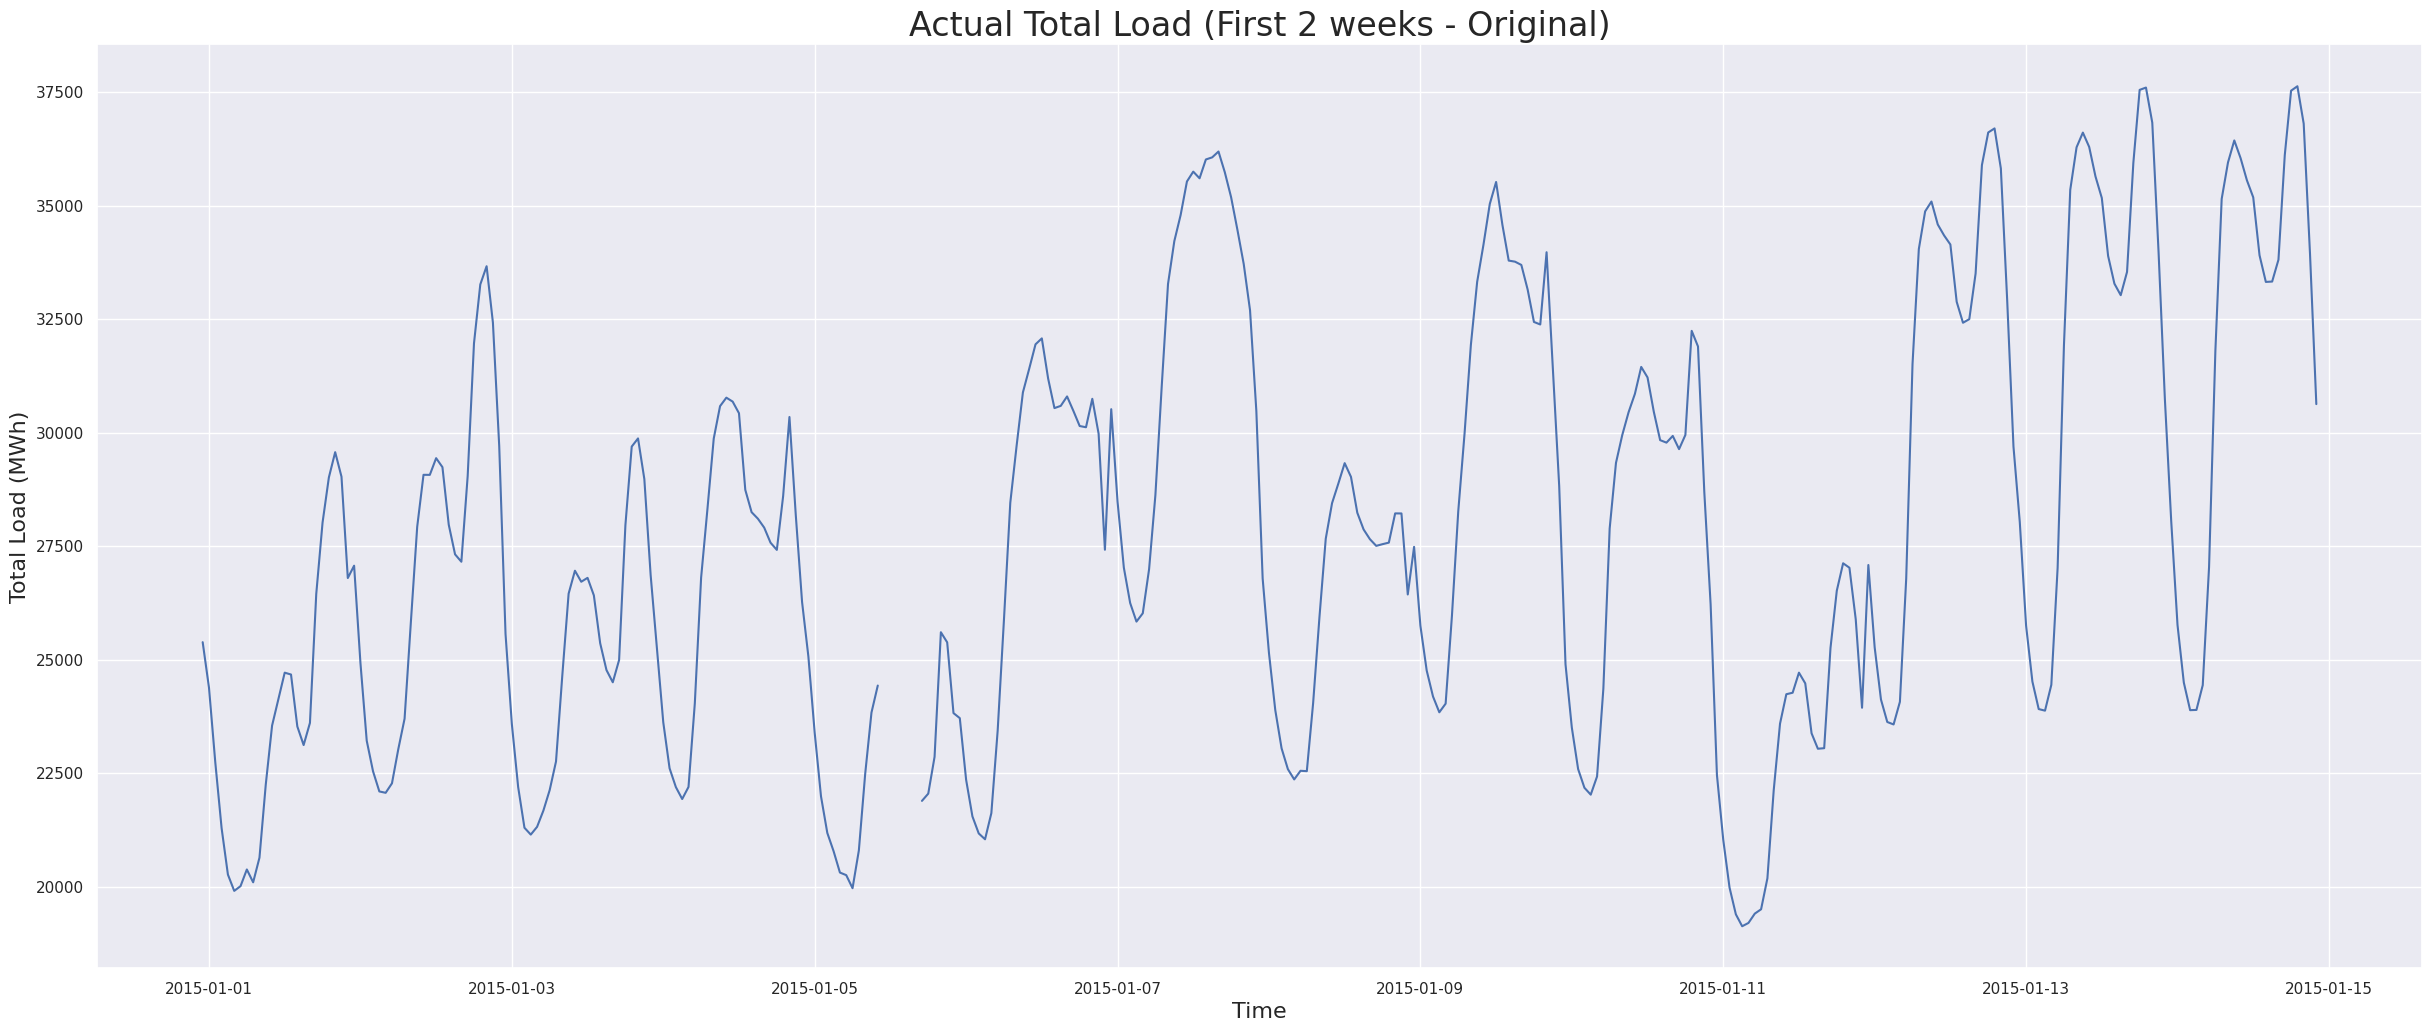

In [ ]:
#Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

In [ ]:
# Display the rows with null values

df_energy[df_energy.isnull().any(axis=1)].tail()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,
2016-11-23 03:00:00+00:00,NaN,900.0,4838.0,4547.0,269.0,1413.0,795.0,435.0,5040.0,60.0,85.0,15.0,227.0,4598.0,3,23469,23112.0,43.19,49.11
2017-11-14 11:00:00+00:00,0.0,0.0,10064.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4325,33805,NaN,60.53,66.17
2017-11-14 18:00:00+00:00,0.0,0.0,12336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128,35592,NaN,68.05,75.45
2018-06-11 16:00:00+00:00,331.0,506.0,7538.0,5360.0,300.0,1.0,1134.0,4258.0,5856.0,52.0,96.0,170.0,269.0,9165.0,125,34752,NaN,69.87,64.93
2018-07-11 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,849,33938,NaN,63.01,69.79


 'ffil' method is used to fill missing (NaN) values in a  DataFrame or Series using an filling technique

In [ ]:
# Fill null values

df_energy.fillna(method='ffill', inplace=True)


In [ ]:
df_energy

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17,26118,25385.0,50.10,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16,24934,24382.0,48.10,64.92
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8,23515,22734.0,47.33,64.48
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2,22642,21286.0,42.27,59.32
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9,21785,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,95.0,85.0,277.0,3113.0,96,30619,30653.0,68.85,77.02
2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,95.0,33.0,280.0,3288.0,51,29932,29735.0,68.40,76.16
2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,94.0,31.0,286.0,3503.0,36,27903,28071.0,66.88,74.30


Saving the Cleaned and organized Energy Data

In [ ]:
df_energy.reset_index(inplace=True)

# Reorder columns to ensure 'time' is the first column
df_energy = df_energy[['time'] + [col for col in df_energy.columns if col != 'time']]

# Now you can save it to a CSV file
df_energy.to_csv('energy_with_time_cleaned.csv', index=False)

In [ ]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_energy.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

time                                           35064
generation biomass                             35060
generation fossil brown coal/lignite           24540
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22449
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
forecast solar day ahead                       34525
total load forecast                            35064
total load actual                              35064
price day ahe

In [ ]:
df_weather.describe().round(2)


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,288.33,291.09,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00,804.00


#Exploratary Data Analys



In [ ]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [ ]:

# Convert columns with int64 type values to float64 type

df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [ ]:
# Convert dt_iso to datetime type, rename it and set it as index

df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

<ipython-input-20-4a930e75b420>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)


In [ ]:
# Find NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather based on all columns.


Discplay the number of observation avaliable in weather data for each city

In [ ]:
# Display the number of rows in each dataframe

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


In [ ]:
# Display all the unique values in the column 'weather_description'

weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [ ]:
# Display all the unique values in the column 'weather_main'

weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [ ]:
# Display all the unique values in the column 'weather_id'

weather_id_unique = df_weather['weather_id'].unique()
weather_id_unique

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])

In [ ]:
# Define a function which will calculate R-squared score for the same column in two dataframes

def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("R-Squared score of {} is {}".format(column, r2.round(3)))

In [ ]:
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')

R-Squared score of weather_description is 0.973
R-Squared score of weather_main is 0.963
R-Squared score of weather_id is 0.921


In [ ]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id',
                              'weather_description', 'weather_icon'], axis=1)

In [ ]:
df_weather.drop(['rain_3h'], axis = 1 , inplace = True)


Saving the cleaned weather Data

In [ ]:
# Assuming df_weather has 'time' as its index
df_weather.reset_index(inplace=True)

# Reorder columns to ensure 'time' is the first column
df_weather = df_weather[['time'] + [col for col in df_weather.columns if col != 'time']]

# Now you can save it to a CSV file
df_weather.to_csv('Weather_with_time_column.csv', index=False)


In [ ]:
df_weather

,time,index,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
0,2014-12-31 23:00:00+00:00,0,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0
1,2015-01-01 00:00:00+00:00,1,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0
2,2015-01-01 01:00:00+00:00,2,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0
3,2015-01-01 02:00:00+00:00,3,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0
4,2015-01-01 03:00:00+00:00,4,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
175315,2018-12-31 18:00:00+00:00,175315,287.760,287.150,288.150,1028.0,54.0,3.0,30.0,0.0,0.0,0.0
175316,2018-12-31 19:00:00+00:00,175316,285.760,285.150,286.150,1029.0,62.0,3.0,30.0,0.0,0.0,0.0
175317,2018-12-31 20:00:00+00:00,175317,285.150,285.150,285.150,1028.0,58.0,4.0,50.0,0.0,0.0,0.0
175318,2018-12-31 21:00:00+00:00,175318,284.150,284.150,284.150,1029.0,57.0,4.0,60.0,0.0,0.0,0.0


## Merging cleaned Datasets

In [ ]:

# Load the cleaned datasets
df_weather = pd.read_csv('/content/Weather_with_time_column.csv')
df_energy = pd.read_csv('/content/energy_with_time_cleaned.csv')


In [ ]:
df_weather['time'] = pd.to_datetime(df_weather['time'])
df_energy['time'] = pd.to_datetime(df_energy['time'])

In [ ]:

# Group by 'time' and take the mean for each time hour
df_weather_avg = df_weather.groupby('time').mean().reset_index()

In [ ]:
df_merged = pd.merge(df_energy, df_weather_avg, on='time', how='inner')


In [ ]:
df_merged.to_csv('Merged_weather_energy.csv', index=False)
df_merged.head()


,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0


In [ ]:
df_merged = pd.read_csv('/content/Merged_weather_energy (3).csv')


In [ ]:
df_merged

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,...,284.470000,283.350000,285.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0
35060,2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,...,282.294000,280.950000,283.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0
35061,2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,...,280.850000,280.350000,281.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0
35062,2018-12-31 21:00:00+00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,...,279.718000,278.750000,280.750000,1030.2,70.0,2.8,230.0,0.0,0.0,0.0


## Visualization

In [ ]:
def feat_corr(input_df):
    corr = input_df.corr()
    plt.figure(figsize=(15,12))
    #plot heat map
    g=sns.heatmap(corr,annot=True,cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title('Feature Correlation')

    return plt.show()

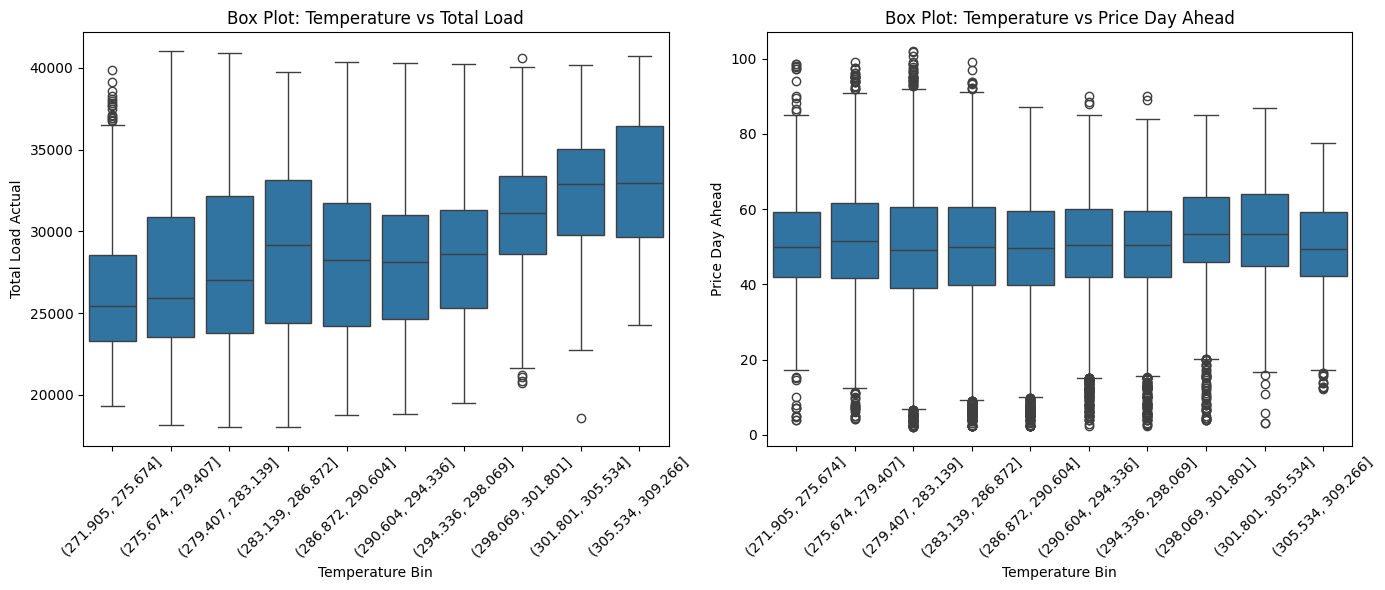

In [ ]:
plt.figure(figsize=(14, 6))

# Create bins for temperature
df_merged['temp_bin'] = pd.cut(df_merged['temp'], bins=10)

# Box plot for Temperature vs Total Load
plt.subplot(1, 2, 1)
sns.boxplot(x='temp_bin', y='total load actual', data=df_merged)
plt.xticks(rotation=45)
plt.xlabel('Temperature Bin')
plt.ylabel('Total Load Actual')
plt.title('Box Plot: Temperature vs Total Load')

# Box plot for Temperature vs Price
plt.subplot(1, 2, 2)
sns.boxplot(x='temp_bin', y='price day ahead', data=df_merged)
plt.xticks(rotation=45)
plt.xlabel('Temperature Bin')
plt.ylabel('Price Day Ahead')
plt.title('Box Plot: Temperature vs Price Day Ahead')

plt.tight_layout()
plt.show()




**Temperature vs. Total Load:**

* The left box plot shows how total electricity load varies with temperature bins.
  
*   We observe that as temperatures increase, the total load tends to decrease. This inverse relationship suggests that warmer weather leads to reduced energy consumption.

*   The spread of data points within each temperature bin indicates variability in load demand.



**Temperature vs. Price Day Ahead**

*   The right box plot illustrates the impact of temperature on electricity prices (day ahead).

*   Prices tend to be higher during colder temperatures, possibly due to increased heating demand.

*   The interquartile range (box) widens for lower temperatures, indicating greater price fluctuations.

*   Outliers at extreme temperatures suggest exceptional pricing conditions.


**Overall Insights:**

*   Temperature plays a crucial role in both load and pricing dynamics.

*   Energy planners and traders should consider weather forecasts when predicting demand and setting pricing strategies.

*   Further analysis could explore seasonality, time-of-day effects, and other factors influencing these relationships.




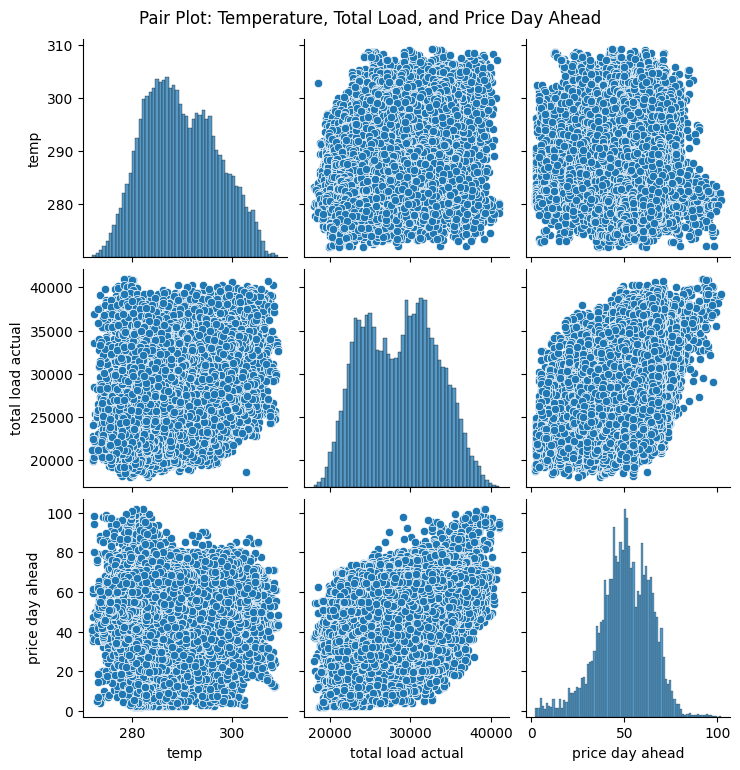

In [ ]:
sns.pairplot(df_merged[['temp', 'total load actual', 'price day ahead']])
plt.suptitle('Pair Plot: Temperature, Total Load, and Price Day Ahead', y=1.02)
plt.show()


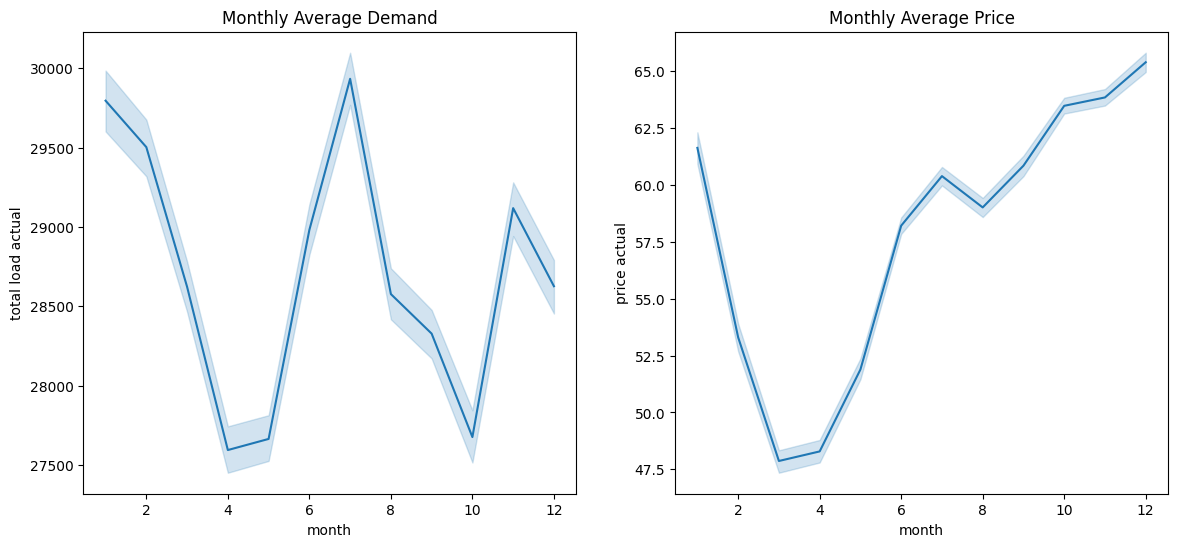

In [ ]:
# Extract month from the time column
df_merged['time'] = pd.to_datetime(df_merged['time'])

df_merged['month'] = df_merged['time'].dt.month

# Line plot for monthly demand
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x='month', y='total load actual', data=df_merged, estimator='mean')
plt.title('Monthly Average Demand')

# Line plot for monthly price
plt.subplot(1, 2, 2)
sns.lineplot(x='month', y='price actual', data=df_merged, estimator='mean')
plt.title('Monthly Average Price')
plt.show()


The plots depict the monthly average demand and price for a certain commodity over a year. The left plot shows the total load actual (demand) fluctuating, with peaks around months 6 and 9 and troughs around months 4 and 10. The right plot indicates the price actual, which generally decreases until month 4 and then steadily increases towards the end of the year. Both plots include a shaded area representing the confidence interval around the actual values.

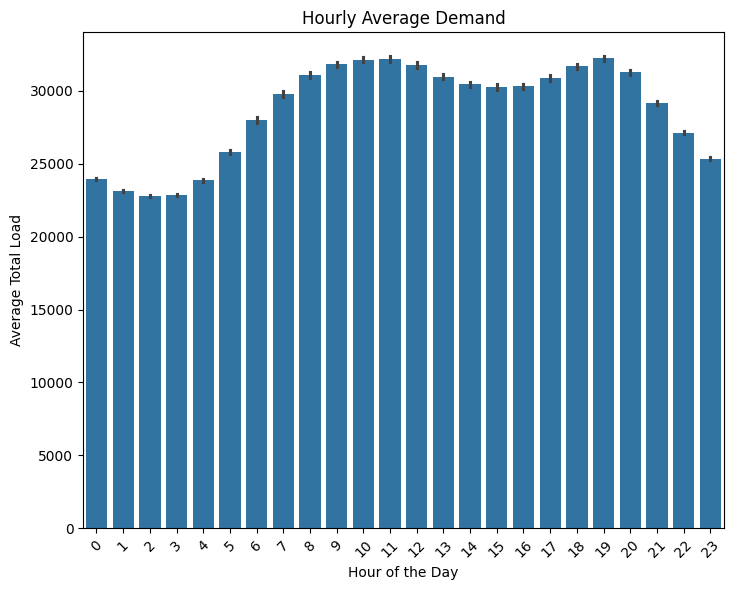

In [ ]:
df_merged['hour'] = df_merged['time'].dt.hour

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='hour', y='total load actual', data=df_merged, estimator='mean')  # Change lineplot to barplot
plt.title('Hourly Average Demand')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Total Load')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust spacing between subplots and elements
plt.show()

The above plot shows the Avergae total load by day ahed we can see the load is high during the business hours throuhghout the day and low during night and non business hours

<ipython-input-9-5802548326c8>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='total load actual', data=avg_demand_by_month, palette="viridis")


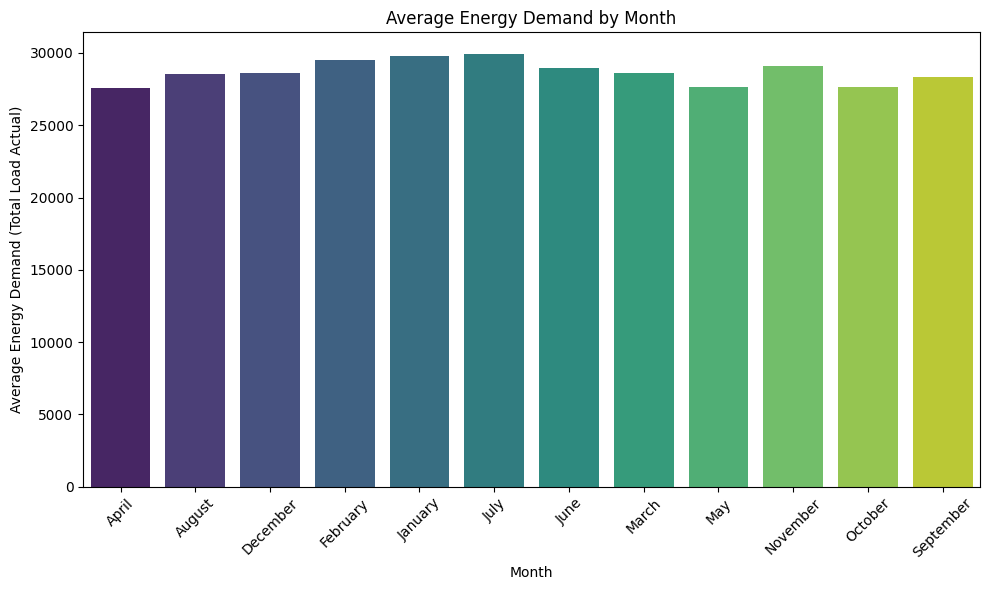

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'time' column is in datetime format
df_merged['time'] = pd.to_datetime(df_merged['time'])

# Extract month name from 'time' column
df_merged['month'] = df_merged['time'].dt.month_name()

# Calculate average energy demand (total load actual) by month
avg_demand_by_month = df_merged.groupby('month')['total load actual'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='total load actual', data=avg_demand_by_month, palette="viridis")
plt.title('Average Energy Demand by Month')
plt.xlabel('Month')
plt.ylabel('Average Energy Demand (Total Load Actual)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


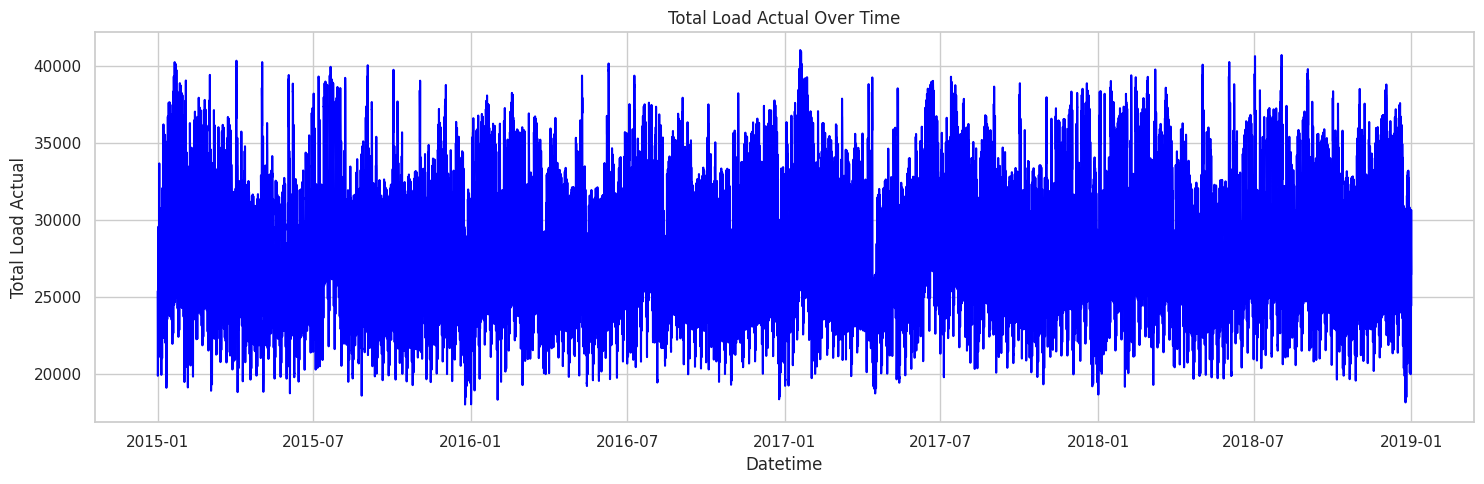

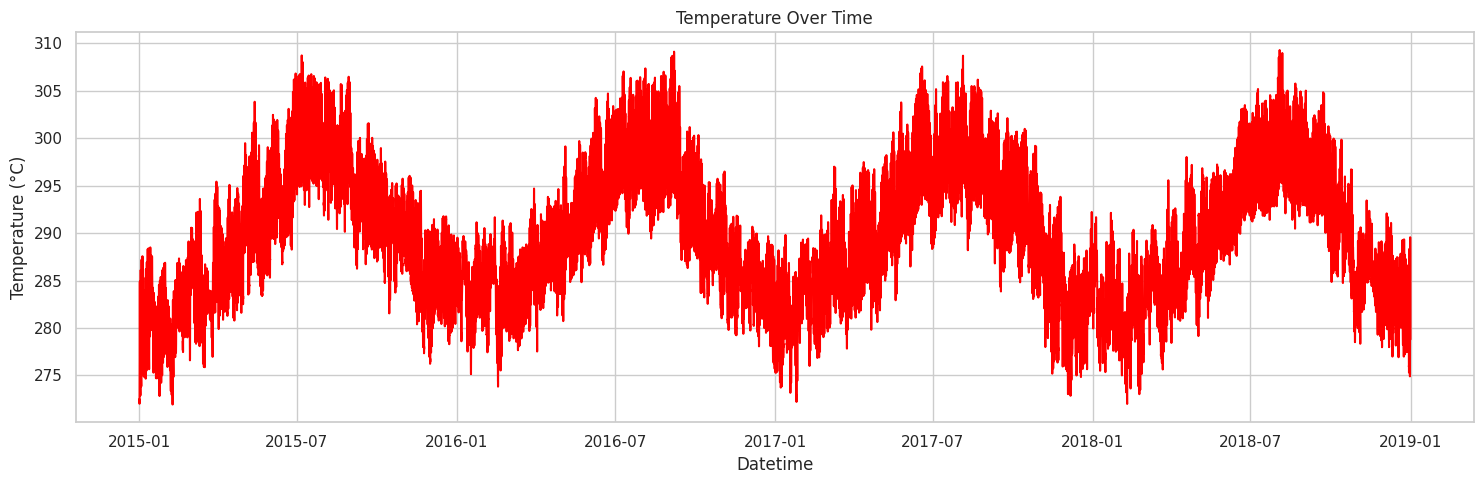

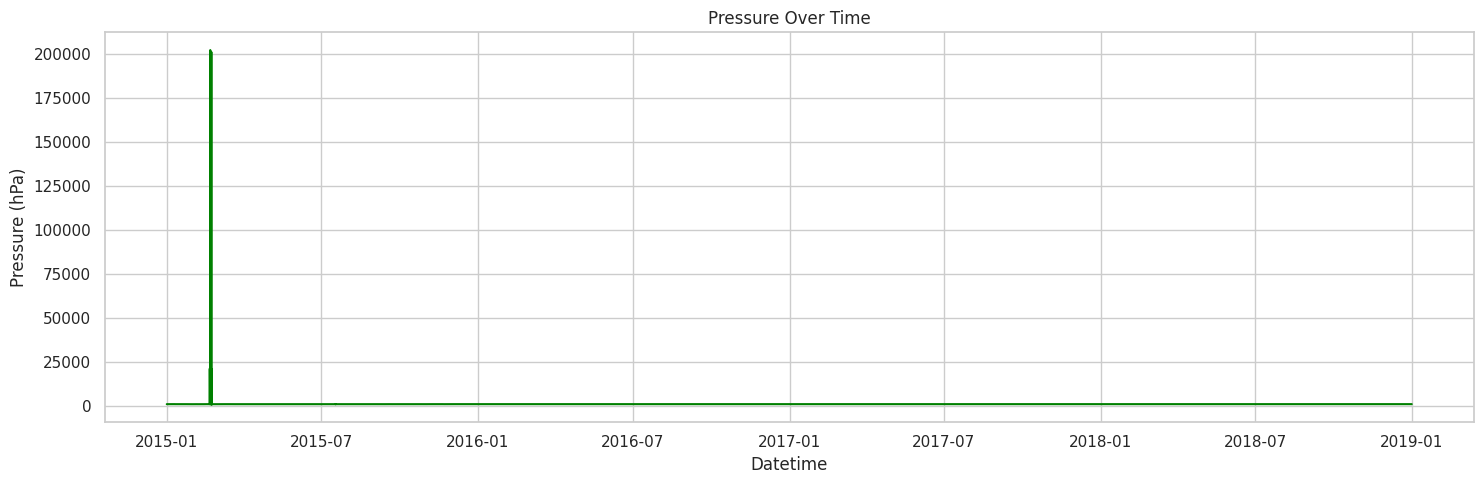

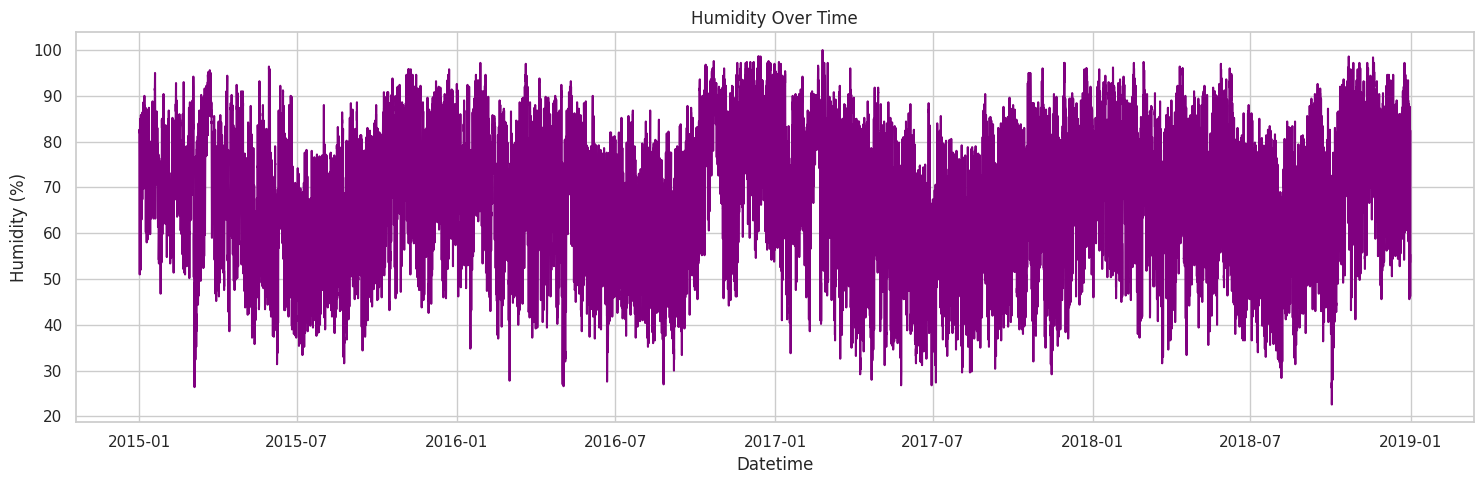

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot Total Load Actual over Time
plt.figure(figsize=(15, 5))
sns.lineplot(x='time', y='total load actual', data=df_merged, color='blue')
plt.title('Total Load Actual Over Time')
plt.ylabel('Total Load Actual')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()

# Plot Temperature over Time
plt.figure(figsize=(15, 5))
sns.lineplot(x='time', y='temp', data=df_merged, color='red')
plt.title('Temperature Over Time')
plt.ylabel('Temperature (°C)')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()

# Plot Pressure over Time
plt.figure(figsize=(15, 5))
sns.lineplot(x='time', y='pressure', data=df_merged, color='green')
plt.title('Pressure Over Time')
plt.ylabel('Pressure (hPa)')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()

# Plot Humidity over Time
plt.figure(figsize=(15, 5))
sns.lineplot(x='time', y='humidity', data=df_merged, color='purple')
plt.title('Humidity Over Time')
plt.ylabel('Humidity (%)')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()


 prediction of price actual and price day ahed

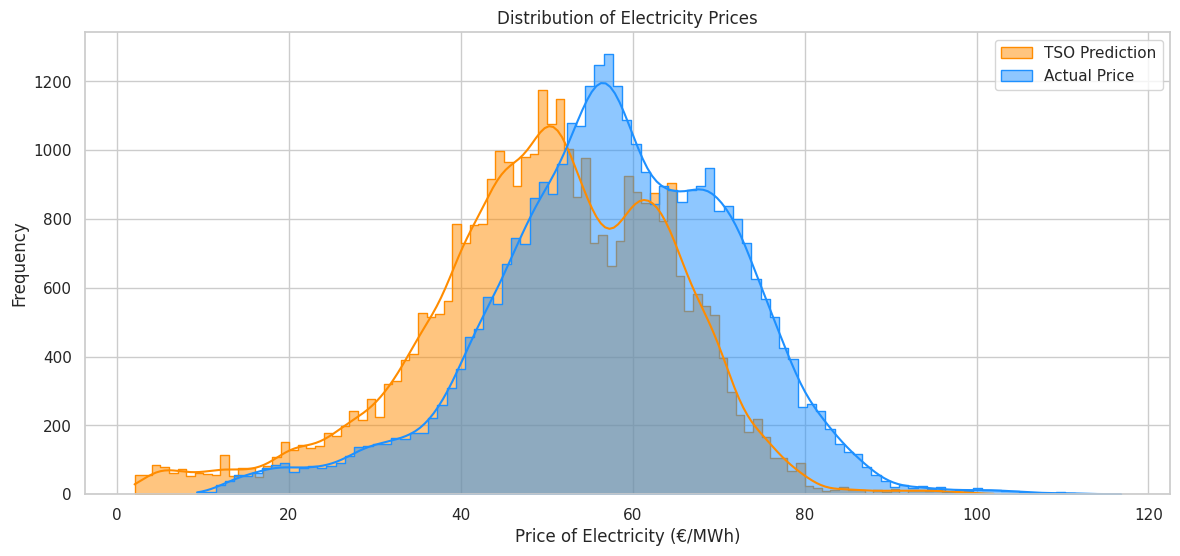

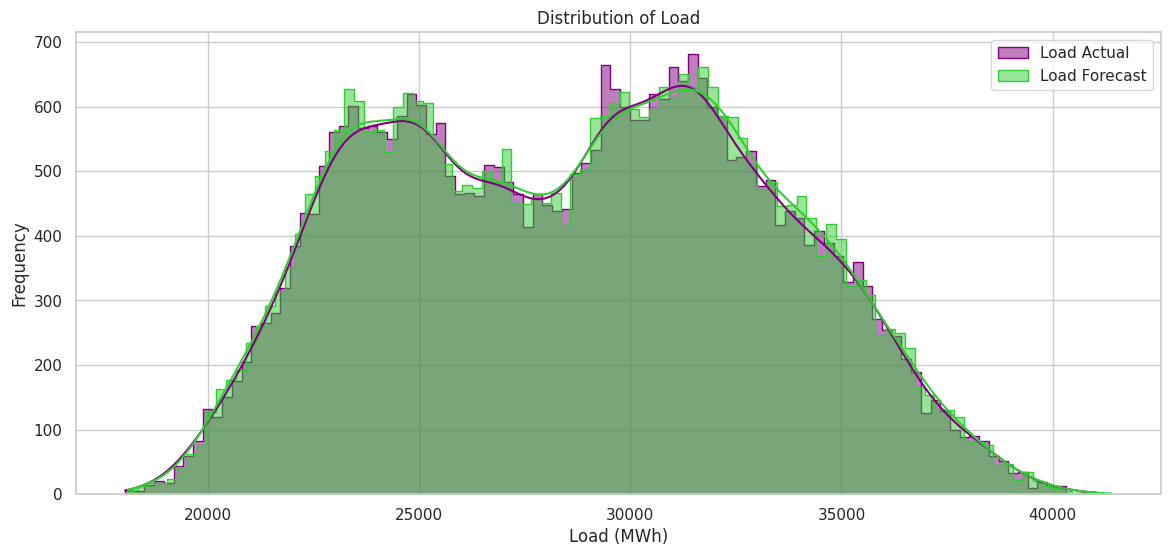

In [ ]:

sns.set(style="whitegrid")

# Price of Electricity
plt.figure(figsize=(14, 6))
gr = sns.histplot(df_merged['price day ahead'], bins=100, label='TSO Prediction', element="step", color='darkorange', kde=True)
gr = sns.histplot(df_merged['price actual'], bins=100, label='Actual Price', element="step", color='dodgerblue', kde=True)

gr.set(xlabel="Price of Electricity (€/MWh)", ylabel="Frequency")
plt.title("Distribution of Electricity Prices")
plt.legend()
plt.show()

# Load
plt.figure(figsize=(14, 6))
gr = sns.histplot(df_merged['total load actual'], bins=100, label='Load Actual', element="step", color='purple', kde=True)
gr = sns.histplot(df_merged['total load forecast'], bins=100, label='Load Forecast', element="step", color='limegreen', kde=True)

gr.set(xlabel="Load (MWh)", ylabel="Frequency")
plt.title("Distribution of Load")
plt.legend()
plt.show()


Here TSO stands for Transmission System Operator. In the context of energy markets, TSOs predict the day-ahead electricity prices based on various factors such as demand forecasts generation capacity, and market conditions. These predictions are crucial for planning and balancing the electricity grid.


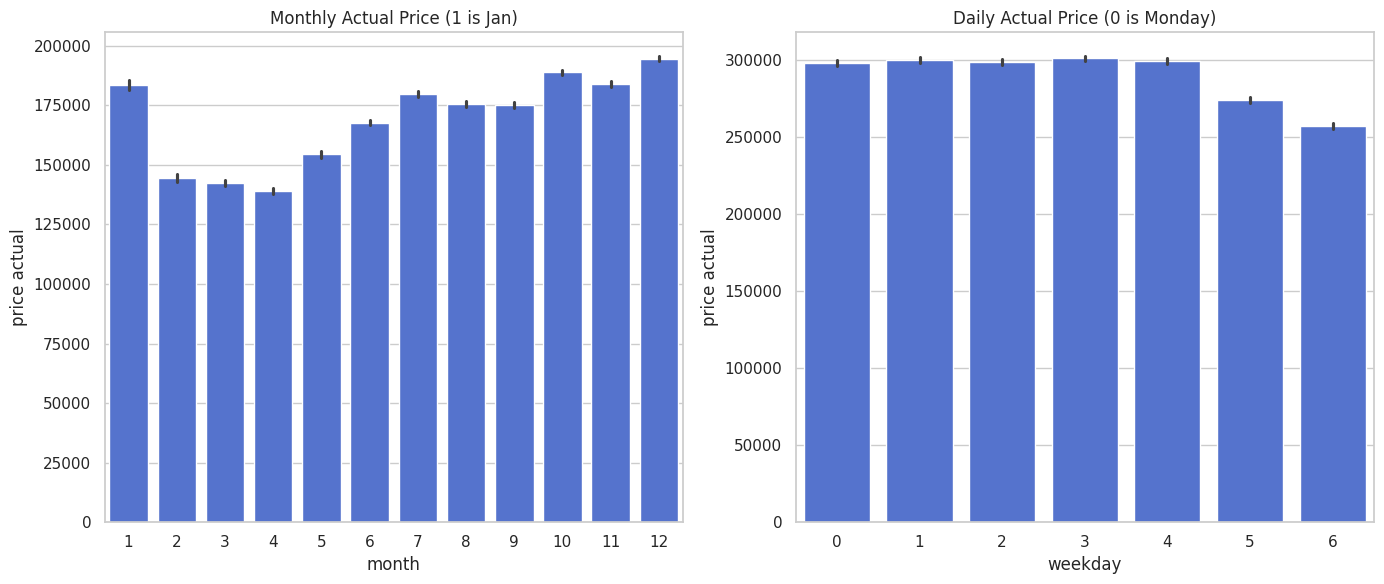

In [ ]:


# Add 'month' and 'weekday' columns
df_merged['month'] = df_merged['time'].dt.month
df_merged['weekday'] = df_merged['time'].dt.weekday

# Create subplots
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.set(style="darkgrid")

# Bar plot for Monthly actual price
sns.barplot(
    x="month",
    y="price actual",
    data=df_merged,
    estimator=sum,
    color='royalblue',
    ax=axes[0]
)
axes[0].set_title('Monthly Actual Price (1 is Jan)')

# Bar plot for Daily actual price
sns.barplot(
    x="weekday",
    y="price actual",
    data=df_merged,
    estimator=sum,
    color='royalblue',
    ax=axes[1]
)
axes[1].set_title('Daily Actual Price (0 is Monday)')

# Adjust layout
plt.tight_layout()
plt.show()


The plots show the actual price data over different periods.


* The left plot illustrates the monthly actual price, with January (month 1)
 having the highest prices, a dip in the middle months, and a recovery towards the end of the year, peaking in December (month 12).


*  The right plot depicts the daily actual price distribution across the weekdays, where prices remain relatively stable from Monday to Thursday but drop slightly on Fridays and weekends.

*   Both plots feature error bars to indicate the variability or confidence intervals around the mean prices


  


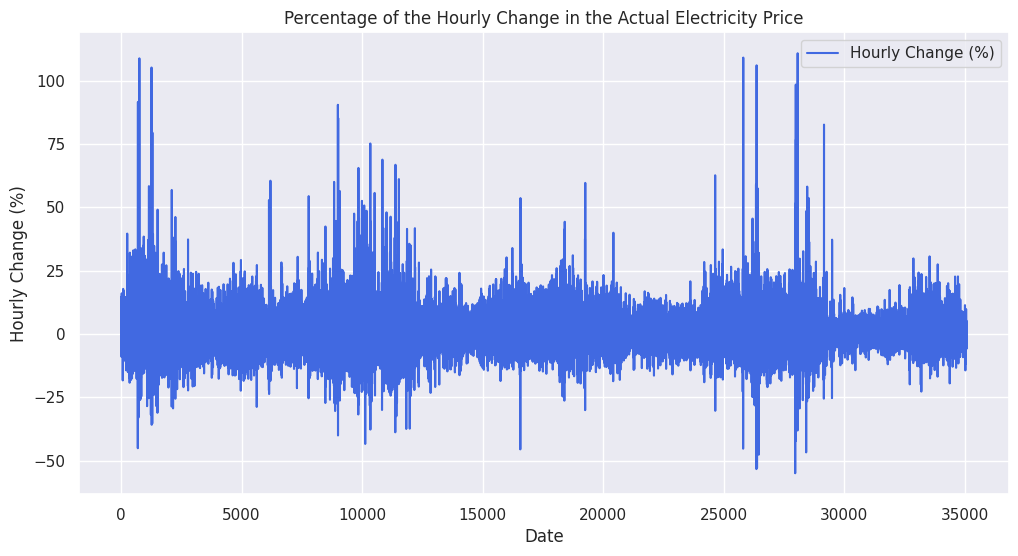

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


change = df_merged['price actual'].pct_change().mul(100)

plt.figure(figsize=(12, 6))
plt.plot(change, label='Hourly Change (%)', color='royalblue')

plt.xlabel('Date')
plt.ylabel('Hourly Change (%)')
plt.title('Percentage of the Hourly Change in the Actual Electricity Price')
plt.legend()
plt.show()


This plot shows the percentage of hourly changes in the actual electricity price over a given period. The x-axis represents the time in hours, and the y-axis shows the percentage change in price. The plot exhibits significant volatility, with hourly changes frequently oscillating between positive and negative values. Large spikes, both positive and negative, indicate periods of substantial price fluctuations, suggesting high volatility in electricity prices within short time frames.

Predict based upon the price actual and price day ahed

In [ ]:


y_scaler_actual = MinMaxScaler()
y_scaler_dayahead = MinMaxScaler()

train_cutoff = int(0.8*df_merged.shape[0])
val_cutoff = int(0.9*df_merged.shape[0])

y_price_actual   = df_merged[['price actual']]
y_price_dayahead = df_merged[['price day ahead']]

y_scaler_actual.fit(y_price_actual[:train_cutoff])
actual_norm = y_scaler_actual.transform(y_price_actual)

y_scaler_dayahead.fit(df_merged[['price day ahead']][:train_cutoff])
dayahead_norm = y_scaler_dayahead.transform(y_price_dayahead)

print(f' mean absolute error for normalized acutal price and TSO predcition is : {round(mean_absolute_error(actual_norm, dayahead_norm),3)}')

 mean absolute error for normalized acutal price and TSO predcition is : 0.071


Here TSO stands for Transmission System Operator. In the context of energy markets, TSOs predict the day-ahead electricity prices based on various factors such as demand forecasts generation capacity, and market conditions. These predictions are crucial for planning and balancing the electricity grid.

TSO prediction output mean **absolute error between the normalized actual prices and the day-ahead prices**, which are typically predicted by TSOs.

In [ ]:
df_merged

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all,temp_bin,month,hour,weekday
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,82.4,2.0,135.2,0.0,0.0,0.0,"(271.905, 275.674]",12,23,2
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,82.4,2.0,135.8,0.0,0.0,0.0,"(271.905, 275.674]",1,0,3
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,82.0,2.4,119.0,0.0,0.0,0.0,"(271.905, 275.674]",1,1,3
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,82.0,2.4,119.2,0.0,0.0,0.0,"(271.905, 275.674]",1,2,3
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,82.0,2.4,118.4,0.0,0.0,0.0,"(271.905, 275.674]",1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,...,73.6,1.4,151.4,0.0,0.0,0.0,"(283.139, 286.872]",12,18,0
35060,2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,...,68.0,1.8,160.4,0.0,0.0,0.0,"(279.407, 283.139]",12,19,0
35061,2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,...,71.4,2.6,226.0,0.0,0.0,0.0,"(279.407, 283.139]",12,20,0
35062,2018-12-31 21:00:00+00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,...,70.0,2.8,230.0,0.0,0.0,0.0,"(279.407, 283.139]",12,21,0


# Feature Engineering

> Adding the hour and business hour column



In [ ]:


df_merged['time'] = pd.to_datetime(df_merged['time'])

# Extract the hour from the time column
df_merged['hour'] = df_merged['time'].dt.hour

# Create 'business hour' feature using vectorized operations
df_merged['business hour'] = np.where(
    ((df_merged['hour'] > 8) & (df_merged['hour'] < 14)) | ((df_merged['hour'] > 16) & (df_merged['hour'] < 21)),
    2,
    np.where((df_merged['hour'] >= 14) & (df_merged['hour'] <= 16), 1, 0)
)

# Drop the 'hour' column if not needed
df_merged.drop(columns='hour', inplace=True)

df_merged.head()


,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all,temp_bin,month,weekday,year,business hour
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,2.0,135.2,0.0,0.0,0.0,"(271.905, 275.674]",12,2,2014,0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,2.0,135.8,0.0,0.0,0.0,"(271.905, 275.674]",1,3,2015,0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,2.4,119.0,0.0,0.0,0.0,"(271.905, 275.674]",1,3,2015,0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,2.4,119.2,0.0,0.0,0.0,"(271.905, 275.674]",1,3,2015,0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,2.4,118.4,0.0,0.0,0.0,"(271.905, 275.674]",1,3,2015,0


In [ ]:


# Ensure 'time' column is in datetime format
df_merged['time'] = pd.to_datetime(df_merged['time'])

# Generate 'hour', 'weekday', 'month', and 'year' features
df_merged['hour'] = df_merged['time'].dt.hour
df_merged['weekday'] = df_merged['time'].dt.weekday
df_merged['month'] = df_merged['time'].dt.month
df_merged['year'] = df_merged['time'].dt.year

# Create 'business hour' feature using vectorized operations
df_merged['business hour'] = np.where(
    ((df_merged['hour'] > 8) & (df_merged['hour'] < 14)) | ((df_merged['hour'] > 16) & (df_merged['hour'] < 21)),
    2,
    np.where((df_merged['hour'] >= 14) & (df_merged['hour'] <= 16), 1, 0)
)

# Verify the new columns
print(df_merged.head())

# Check the number of columns
print(f"Number of columns: {len(df_merged.columns)}")
print(df_merged.columns)


                       time  generation biomass  \
0 2014-12-31 23:00:00+00:00               447.0   
1 2015-01-01 00:00:00+00:00               449.0   
2 2015-01-01 01:00:00+00:00               448.0   
3 2015-01-01 02:00:00+00:00               438.0   
4 2015-01-01 03:00:00+00:00               428.0   

   generation fossil brown coal/lignite  generation fossil gas  \
0                                 329.0                 4844.0   
1                                 328.0                 5196.0   
2                                 323.0                 4857.0   
3                                 254.0                 4314.0   
4                                 187.0                 4130.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                  162.0   
1                       4755.0                  158.0   
2                       4581.0                  157.0   
3                       4131.0                  160.0   
4          

In [ ]:
df_merged.drop(['total load forecast'], axis = 1, inplace = True)


In [ ]:

df_merged['time'] = pd.to_datetime(df_merged['time'])

# Generate 'weekday' feature
df_merged['weekday'] = df_merged['time'].dt.weekday

# Generate 'weekend' feature
df_merged['weekend'] = np.where(df_merged['weekday'] == 6, 2, np.where(df_merged['weekday'] == 5, 1, 0))

# Verify the new column
print(df_merged[['time', 'weekday', 'weekend']].head())


                       time  weekday  weekend
0 2014-12-31 23:00:00+00:00        2        0
1 2015-01-01 00:00:00+00:00        3        0
2 2015-01-01 01:00:00+00:00        3        0
3 2015-01-01 02:00:00+00:00        3        0
4 2015-01-01 03:00:00+00:00        3        0


In [ ]:
if 'temp_max' in df_merged.columns and 'temp_min' in df_merged.columns:
    # Generate 'temp_range' feature
    df_merged['temp_range'] = abs(df_merged['temp_max'] - df_merged['temp_min'])

    # Verify the new column
    print(df_merged[['time', 'temp_max', 'temp_min', 'temp_range']].head())
else:
    print("Columns 'temp_max' and 'temp_min' are not present in the DataFrame.")


                       time    temp_max    temp_min  temp_range
0 2014-12-31 23:00:00+00:00  272.491463  272.491463         0.0
1 2015-01-01 00:00:00+00:00  272.512700  272.512700         0.0
2 2015-01-01 01:00:00+00:00  272.099137  272.099137         0.0
3 2015-01-01 02:00:00+00:00  272.089469  272.089469         0.0
4 2015-01-01 03:00:00+00:00  272.145900  272.145900         0.0


In [ ]:
df_merged = pd.read_csv('/content/Merged_feature engineered.csv')


In [ ]:
df_merged

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,snow_3h,clouds_all,temp_bin,month,weekday,year,business hour,hour,weekend,temp_range
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,0.0,0.0,"(271.905, 275.674]",12,2,2014,0,23,0,0.0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,0,0,0.0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,1,0,0.0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,2,0,0.0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,3,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,...,0.0,0.0,"(283.139, 286.872]",12,0,2018,2,18,0,2.2
35060,2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,...,0.0,0.0,"(279.407, 283.139]",12,0,2018,2,19,0,2.4
35061,2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,...,0.0,0.0,"(279.407, 283.139]",12,0,2018,2,20,0,1.0
35062,2018-12-31 21:00:00+00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,...,0.0,0.0,"(279.407, 283.139]",12,0,2018,0,21,0,2.0


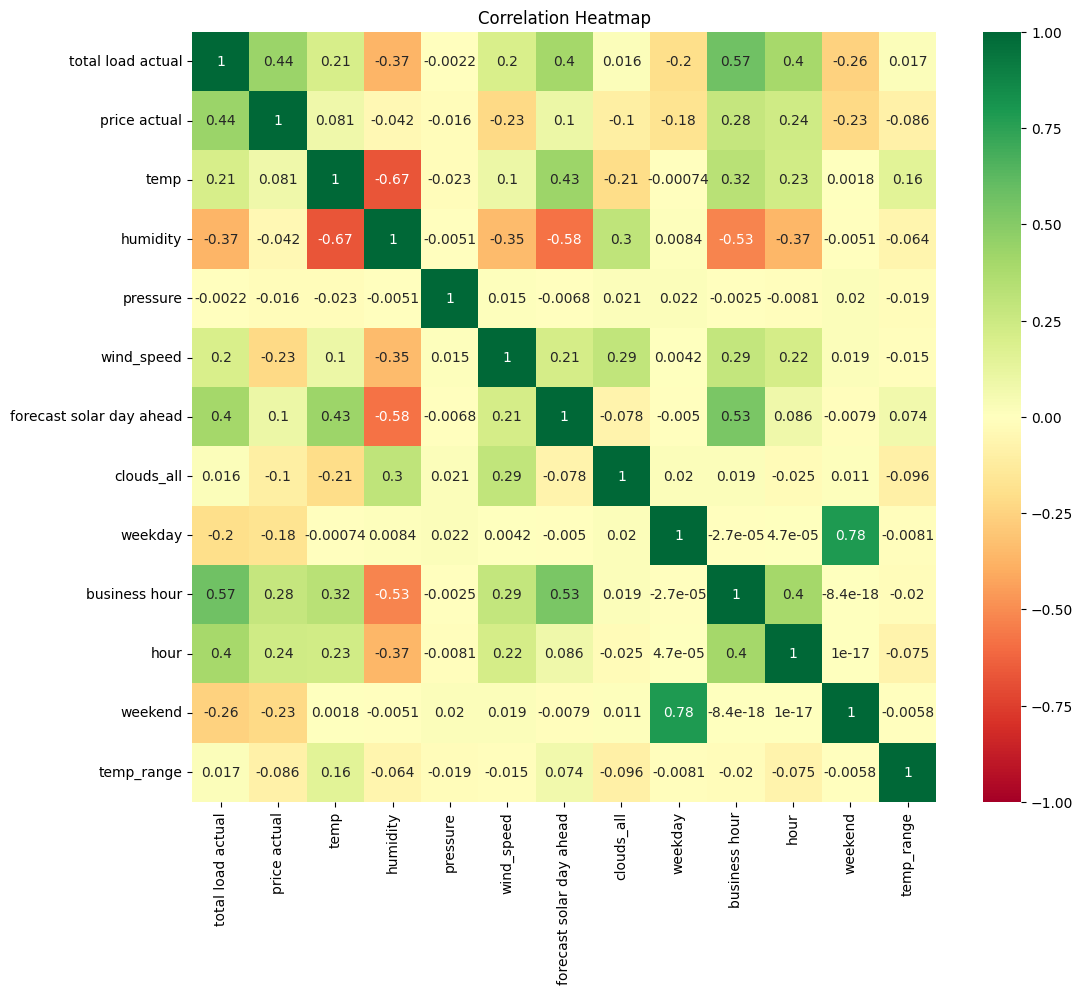

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of relevant features
features = ['total load actual', 'price actual', 'temp', 'humidity', 'pressure', 'wind_speed',
            'forecast solar day ahead', 'clouds_all', 'weekday', 'business hour', 'hour','weekend','temp_range']

# Select the relevant columns from df_merged
df_selected = df_merged[features]

# Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


Total Load Actual shows a positive correlation with Business Hour (0.57) and Hour (0.4), indicating that power load increases during business hours and varies with the time of day

Price Actual is moderately correlated with Total Load Actual (0.44) and Business Hour (0.28), suggesting that electricity prices rise with higher loads and during business hours

Temperature has a negative correlation with Humidity (-0.67), meaning that higher temperatures are associated with lower humidity levels

Business Hour is highly correlated with Hour (0.4) business activities are closely tied to specific hours of the day.

In [ ]:
df_merged.isnull().sum(axis=0)

time                                           0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
total load actual                              0
price day ahead                                0
price actual                                   0
index                                          0
temp                

In [ ]:
#Saving the Merged data With featre Engineering
df_merged.to_csv('Merged_engineered_data.csv', index=False)


In [ ]:
df_merged=pd.read_csv('/content/Merged_engineered_data.csv')

In [ ]:
df_merged

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,snow_3h,clouds_all,temp_bin,month,weekday,year,business hour,hour,weekend,temp_range
0,2014-12-31 23:00:00+00:00,447.000,329.000,4844.000,4821.000,162.000,863.000,1051.000,1899.000,7096.000,...,0.000,0.000,"(271.905, 275.674]",12,2,2014,0,23,0,0.000
1,2015-01-01 00:00:00+00:00,449.000,328.000,5196.000,4755.000,158.000,920.000,1009.000,1658.000,7096.000,...,0.000,0.000,"(271.905, 275.674]",1,3,2015,0,0,0,0.000
2,2015-01-01 01:00:00+00:00,448.000,323.000,4857.000,4581.000,157.000,1164.000,973.000,1371.000,7099.000,...,0.000,0.000,"(271.905, 275.674]",1,3,2015,0,1,0,0.000
3,2015-01-01 02:00:00+00:00,438.000,254.000,4314.000,4131.000,160.000,1503.000,949.000,779.000,7098.000,...,0.000,0.000,"(271.905, 275.674]",1,3,2015,0,2,0,0.000
4,2015-01-01 03:00:00+00:00,428.000,187.000,4130.000,3840.000,156.000,1826.000,953.000,720.000,7097.000,...,0.000,0.000,"(271.905, 275.674]",1,3,2015,0,3,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.000,0.000,7634.000,2628.000,178.000,1.000,1135.000,4836.000,6073.000,...,0.000,0.000,"(283.139, 286.872]",12,0,2018,2,18,0,2.200
35060,2018-12-31 19:00:00+00:00,296.000,0.000,7241.000,2566.000,174.000,1.000,1172.000,3931.000,6074.000,...,0.000,0.000,"(279.407, 283.139]",12,0,2018,2,19,0,2.400
35061,2018-12-31 20:00:00+00:00,292.000,0.000,7025.000,2422.000,168.000,50.000,1148.000,2831.000,6076.000,...,0.000,0.000,"(279.407, 283.139]",12,0,2018,2,20,0,1.000
35062,2018-12-31 21:00:00+00:00,293.000,0.000,6562.000,2293.000,163.000,108.000,1128.000,2068.000,6075.000,...,0.000,0.000,"(279.407, 283.139]",12,0,2018,0,21,0,2.000


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
df_merged['time'] = df_merged['time'].astype(str)

# Convert the time column to datetime, coerce errors to NaT
df_merged['time'] = pd.to_datetime(df_merged['time'], errors='coerce')

# Drop rows where the time column is NaT
df_merged = df_merged.dropna(subset=['time'])

# Set the time column as the index
df_merged.set_index('time', inplace=True)

# Display the first few rows of the dataset
df_merged.head()


,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,snow_3h,clouds_all,temp_bin,month,weekday,year,business hour,hour,weekend,temp_range
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,0.0,0.0,"(271.905, 275.674]",12,2,2014,0,23,0,0.0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,0,0,0.0
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,1,0,0.0
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,2,0,0.0
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,3,0,0.0


Ensuring All Feature Columns are Numeric and giving Target variable

In [ ]:
# Drop non-numeric columns
relevant_features = [
    'generation biomass','generation fossil brown coal/lignite','generation fossil gas','generation fossil hard coal','generation fossil oil',
    'generation hydro run-of-river and poundage','generation hydro water reservoir'
    ,'generation nuclear','generation other',	'generation other renewable','generation wind onshore','total load actual','temp','pressure','wind_speed','rain_1h','snow_3h'
    ,'clouds_all','weekday','month','business hour','hour','weekend'
]

# Filter the features and target variable
features = df_merged[relevant_features]
target_price = df_merged['price actual']

# Split the Data into Train, Test, and Validation Sets

Training Set (70%) , Validation Set (15%) , Test Set (15%)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(features, target_price, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)



# Train and Evaluate the Linear regression Model for Price

In [ ]:
# Train the model for price actual
model_price = LinearRegression()
model_price.fit(X_train, y_train)



LinearRegression()

In [ ]:
# Function to calculate Adjusted R^2
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))


# Evaluate the Model for Price


In [ ]:
# Predictions
y_pred_price = model_price.predict(X_test)

# Evaluation metrics
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = adjusted_r2(r2_price, X_test.shape[0], X_test.shape[1])
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")


Price Actual Prediction:
MSE: 72.67491264024935
RMSE: 8.52495821926708
R^2: 0.6504359899355922
Adjusted R^2: 0.6480265883728278
MAPE: 0.12604135361965868


MSE 68.64 - This measures the average squared difference between the actual and predicted values. Lower values are better.

RMSE is the square root of the MSE and is in the same units as the target variable. It indicates better performance when lower

MAPE indicates the average percentage error between the predicted and actual values. Lower values indicate better performance. A MAPE of 12% is reasonable accuracy but needs improvement.

# Evaluate the Linear regression Model for Load


In [ ]:
relevant_features = [
    'generation biomass','generation fossil brown coal/lignite',	'generation fossil gas','generation fossil hard coal','generation fossil oil',
    'generation hydro water reservoir'
    ,'generation nuclear','generation other',	'generation other renewable',	'generation wind onshore','price day ahead','price actual','temp','pressure','wind_speed','rain_1h','snow_3h'
    ,'clouds_all','weekday','month','business hour','hour','weekend'
]

# Filter the features and target variable
features = df_merged[relevant_features]
target_load = df_merged['total load actual']

# Split the data into training, validation, and test sets
X_train_load, X_temp, y_train_load, y_temp = train_test_split(features, target_load, train_size=0.8, random_state=42)
X_val_load, X_test_load, y_val_load, y_test_load = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)



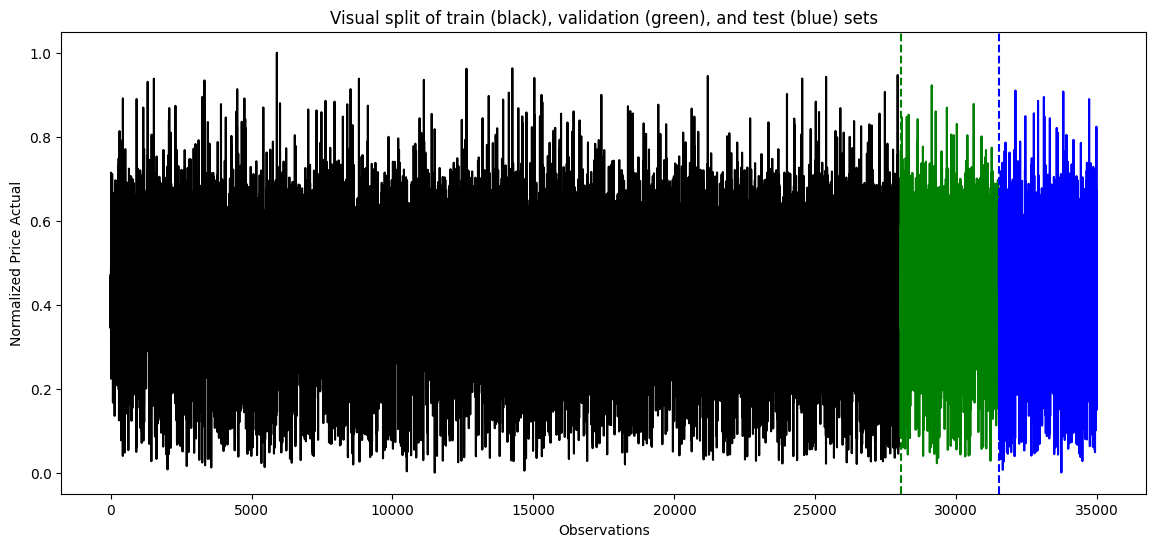

In [ ]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Define the windowing function
def windowing(X_input, y_input, history_size):
    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data.append(X_input[i - history_size: i, :])
        labels.append(y_input[i])
    return np.array(data), np.array(labels).reshape(-1, 1)

# Normalize the features and target variable
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()

# Fit and transform features
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

X_train_load = scaler_X.fit_transform(X_train_load)
X_val_load = scaler_X.transform(X_val_load)
X_test_load = scaler_X.transform(X_test_load)

# Convert target variables to numpy arrays
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

y_train_load = y_train_load.values.reshape(-1, 1)
y_val_load = y_val_load.values.reshape(-1, 1)
y_test_load = y_test_load.values.reshape(-1, 1)

# Fit and transform target variable
y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

y_train_load = scaler_y.fit_transform(y_train_load)
y_val_load = scaler_y.transform(y_val_load)
y_test_load = scaler_y.transform(y_test_load)


# Plot the train, validation, and test splits
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_train)), y_train, color='black')
plt.plot(range(len(y_train), len(y_train) + len(y_val)), y_val, color='green')
plt.plot(range(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), y_test, color='blue')
plt.axvline(x=len(y_train), color='green', linestyle='--')
plt.axvline(x=len(y_train) + len(y_val), color='blue', linestyle='--')
plt.title('Visual split of train (black), validation (green), and test (blue) sets')
plt.xlabel('Observations')
plt.ylabel('Normalized Price Actual')
plt.show()


In [ ]:
# Train the model for total load actual
model_load = LinearRegression()
model_load.fit(X_train_load, y_train_load)

LinearRegression()

In [ ]:
# Predictions
y_pred_load = model_load.predict(X_test_load)

# Evaluation metrics
mse_load = mean_squared_error(y_test_load, y_pred_load)
rmse_load = np.sqrt(mse_load)
r2_load = r2_score(y_test_load, y_pred_load)
adj_r2_load = adjusted_r2(r2_load, X_test_load.shape[0], X_test_load.shape[1])
mape_load = mean_absolute_percentage_error(y_test_load, y_pred_load)

print("Total Load Actual Prediction:")
print(f"MSE: {mse_load}")
print(f"RMSE: {rmse_load}")
print(f"R^2: {r2_load}")
print(f"Adjusted R^2: {adj_r2_load}")
print(f"MAPE: {mape_load}")


Total Load Actual Prediction:
MSE: 3424259.651565935
RMSE: 1850.4755203908899
R^2: 0.832914835539855
Adjusted R^2: 0.831811488200612
MAPE: 0.05256452568437122


R^2 (Coefficient of Determination): 0.831 - This indicates that about 91.9% of the variance in the target variable is explained by the model, which is a good score.

Adjusted R^2: 0.831 - Similar to R^2, this indicates good model performance.

MAPE (Mean Absolute Percentage Error): 0.052 - A MAPE of 5.2% suggests high accuracy in predictions.

# Decission tree regressor Algorithm

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Train the Decision Tree Regressor model for price actual
model_price = DecisionTreeRegressor(random_state=42)
model_price.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
# Predictions
y_pred_price = model_price.predict(X_test)

In [ ]:
# Evaluation metrics for price actual prediction
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = adjusted_r2(r2_price, X_test.shape[0], X_test.shape[1])
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")

Price Actual Prediction:
MSE: 40.910784687767325
RMSE: 6.396153898067754
R^2: 0.8032204314970546
Adjusted R^2: 0.8018641105194352
MAPE: 0.07096376424581703


In [ ]:
# Train the Decision Tree Regressor model for price actual
model_price = DecisionTreeRegressor(random_state=42)
model_price.fit(X_train, y_train)

# Train the Decision Tree Regressor model for total load actual
model_load = DecisionTreeRegressor(random_state=42)
model_load.fit(X_train_load, y_train_load)

# Predictions
y_pred_price = model_price.predict(X_test)
y_pred_load = model_load.predict(X_test_load)

mse_load = mean_squared_error(y_test_load, y_pred_load)
rmse_load = np.sqrt(mse_load)
r2_load = r2_score(y_test_load, y_pred_load)
adj_r2_load = adjusted_r2(r2_load, X_test_load.shape[0], X_test_load.shape[1])
mape_load = mean_absolute_percentage_error(y_test_load, y_pred_load)

print("\nTotal Load Actual Prediction:")
print(f"MSE: {mse_load}")
print(f"RMSE: {rmse_load}")
print(f"R^2: {r2_load}")
print(f"Adjusted R^2: {adj_r2_load}")
print(f"MAPE: {mape_load}")



Total Load Actual Prediction:
MSE: 2601009.0775591675
RMSE: 1612.7644209738655
R^2: 0.8730849661801894
Adjusted R^2: 0.8722468824081953
MAPE: 0.04012984983201981


The evaluation metrics for the Decision Tree model predicting total load actual indicate a strong performance. The model achieves a high R^2 value of 0.873, signifying that it explains approximately 87.3% of the variance in the data, with a slightly lower adjusted R^2 of 0.872, accounting for the number of predictors. The RMSE is 1612.76, indicating the average magnitude of error is reasonably low. Additionally, the MAPE of 0.0401 shows that the model's predictions are, on average, only 4.01% off from the actual values, reflecting good predictive accuracy.


# Randomforest Model For Price forecast

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_price = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_price.fit(X_train, y_train)

y_pred_price = rf_price.predict(X_test)

In [ ]:
# Train the Random Forest Regressor model for price actual
rf_price = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_price.fit(X_train, y_train)

y_pred_price = rf_price.predict(X_test)

# Evaluation metrics for price actual prediction
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = adjusted_r2(r2_price, X_test.shape[0], X_test.shape[1])
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")


Price Actual Prediction:
MSE: 17.013357805346455
RMSE: 4.12472517937213
R^2: 0.9181662920114231
Adjusted R^2: 0.917602245776005
MAPE: 0.05112834148460832


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Define the parameter distributions
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV using a subset of the data for quicker results
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)
random_search.fit(X_train_sample, y_train_sample)

best_rf_price = random_search.best_estimator_

best_rf_price.fit(X_train, y_train)

y_pred_price = best_rf_price.predict(X_test)

# Evaluation metrics for price actual prediction
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = 1 - ((1 - r2_price) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

print("Results from Randomized Search:")
print(f"The best estimator across ALL searched params: {random_search.best_estimator_}")
print(f"The best score across ALL searched params: {random_search.best_score_}")
print(f"The best parameters across ALL searched params: {random_search.best_params_}")
print()
print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Results from Randomized Search:
The best estimator across ALL searched params: RandomForestRegressor(bootstrap=False, max_depth=50, max_features='log2',
                      min_samples_leaf=2, n_jobs=-1, random_state=42)
The best score across ALL searched params: 0.8131374937521874
The best parameters across ALL searched params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}

Price Actual Prediction:
MSE: 13.223504410568653
RMSE: 3.6364136742907363
R^2: 0.9363953658706882
Adjusted R^2: 0.9359569651759427
MAPE: 0.04764104887051582


The evaluation metrics for the Random Forest model predicting price actual show excellent performance. With an R^2 value of 0.937, the model explains approximately 93.7% of the variance in the data, and the adjusted R^2
is slightly lower at 0.937, indicating a strong fit.

The RMSE of 3.61 suggests a low average error in predictions, while

The MAPE of 0.045 indicates that the model's predictions are, on average, only 4.75% off from the actual values, demonstrating high predictive accuracy.

# Random forest regressor model for load forecasting

In [ ]:
rf_load = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_load.fit(X_train_load, y_train_load)

y_pred_load = rf_load.predict(X_test_load)


In [ ]:
# Evaluation metrics for total load actual prediction
mse_load = mean_squared_error(y_test_load, y_pred_load)
rmse_load = np.sqrt(mse_load)
r2_load = r2_score(y_test_load, y_pred_load)
adj_r2_load = adjusted_r2(r2_load, X_test_load.shape[0], X_test_load.shape[1])
mape_load = mean_absolute_percentage_error(y_test_load, y_pred_load)

print("\nTotal Load Actual Prediction:")
print(f"MSE: {mse_load}")
print(f"RMSE: {rmse_load}")
print(f"R^2: {r2_load}")
print(f"Adjusted R^2: {adj_r2_load}")
print(f"MAPE: {mape_load}")


Total Load Actual Prediction:
MSE: 1035073.7657801824
RMSE: 1017.3857507259389
R^2: 0.9494940547792062
Adjusted R^2: 0.9491605386321841
MAPE: 0.02694584368508167


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Define the hyperparameter grid with more focused values based on domain knowledge
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto']
}

# Create a RandomForestRegressor model
rf_load = RandomForestRegressor(random_state=42, n_jobs=-1)

# Use GridSearchCV to find the best hyperparameters
tuning = GridSearchCV(estimator=rf_load, param_grid=param_grid,
                      scoring='r2', cv=3, n_jobs=-1, verbose=1)
tuning.fit(X_train_load, y_train_load)

# Get the best model
best_rf_load = tuning.best_estimator_

# Make predictions with the best model
y_pred_load = best_rf_load.predict(X_test_load)

# Evaluation metrics for total load actual prediction
mse_load = mean_squared_error(y_test_load, y_pred_load)
rmse_load = np.sqrt(mse_load)
r2_load = r2_score(y_test_load, y_pred_load)
adj_r2_load = adjusted_r2(r2_load, X_test_load.shape[0], X_test_load.shape[1])
mape_load = mean_absolute_percentage_error(y_test_load, y_pred_load)

print("\nTotal Load Actual Prediction:")
print(f"MSE: {mse_load}")
print(f"RMSE: {rmse_load}")
print(f"R^2: {r2_load}")
print(f"Adjusted R^2: {adj_r2_load}")
print(f"MAPE: {mape_load}")
print(f"Best Parameters: {tuning.best_params_}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Total Load Actual Prediction:
MSE: 1019573.590368292
RMSE: 1009.7393675440668
R^2: 0.9502503786627273
Adjusted R^2: 0.9499218569025328
MAPE: 0.026734371973332675
Best Parameters: {'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


The evaluation metrics for the model predicting total load actual show an outstanding performance. The high R^2 value of 0.950 indicates that the model explains 95.0% of the variance in the data, and the adjusted R^2 of 0.950 further confirms this strong fit.

 With an RMSE of 1009.74, the model's prediction errors are relatively low, and the

 MAPE of 2.67% demonstrates that the model's predictions are, on average, only 2.67% off from the actual values, highlighting its high accuracy and reliability.

# Gradient Boosting Price forecasting

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# Initialize and train the Gradient Boosting model for price actual
gbr_price = GradientBoostingRegressor(random_state=42)
gbr_price.fit(X_train, y_train)

y_pred_price = gbr_price.predict(X_test)


In [ ]:
# Evaluation metrics for price actual
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = 1 - ((1 - r2_price) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")

Price Actual Prediction:
MSE: 42.31670165758436
RMSE: 6.505128873249504
R^2: 0.7964580157481753
Adjusted R^2: 0.7950550842082431
MAPE: 0.0964854497176992


# Gradient boosting price model with Parameter tuning

In [ ]:
LR = {'learning_rate': [0.15,0.1,0.10,0.05], 'n_estimators': [100, 150, 200,250]}

tuning = GridSearchCV(estimator = GradientBoostingRegressor(),
                      param_grid = LR, scoring ='r2')

tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.15, 'n_estimators': 250}, 0.8632483105083985)

In [ ]:
gbr_price_tunned = GradientBoostingRegressor(learning_rate=0.15, n_estimators=250, random_state=42)
gbr_price_tunned.fit(X_train, y_train)

# Predict and evaluate for price actual
y_pred_price = gbr_price_tunned.predict(X_test)


In [ ]:
# Evaluation metrics for price actual
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = 1 - ((1 - r2_price) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")

Price Actual Prediction:
MSE: 27.817151709102518
RMSE: 5.274196783312367
R^2: 0.8662003881843192
Adjusted R^2: 0.8652781622556643
MAPE: 0.07755611404999824


# GradientBoosting parameter tuning RandomSearchCv

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Define a smaller parameter distribution
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 5, 6]
}

# Initialize the model
gbr = GradientBoostingRegressor(random_state=42)

# Initialize RandomizedSearchCV with fewer iterations
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_distributions, n_iter=10, scoring='r2', cv=3, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model
best_gbr = random_search.best_estimator_

# Predict using the best model
y_pred_price = best_gbr.predict(X_test)

# Evaluation metrics
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = 1 - ((1 - r2_price) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

# Print the results
print("Results from Random Search:")
print(f"The best estimator across ALL searched params: {random_search.best_estimator_}")
print(f"The best score across ALL searched params: {random_search.best_score_}")
print(f"The best parameters across ALL searched params: {random_search.best_params_}")
print()
print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Results from Random Search:
The best estimator across ALL searched params: GradientBoostingRegressor(max_depth=6, n_estimators=200, random_state=42)
The best score across ALL searched params: 0.9254542225443646
The best parameters across ALL searched params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}

Price Actual Prediction:
MSE: 13.764355540600581
RMSE: 3.7100344392741937
R^2: 0.9337938891988453
Adjusted R^2: 0.9333375575907961
MAPE: 0.05183399427832073



The results from the random search highlight that the best estimator for predicting price actual is a GradientBoostingRegressor with a max_depth of 6 and 200 n_estimators.

The best score achieved across all parameters is 0.9255. The optimal parameters are a subsample of 1.0, n_estimators of 200, max_depth of 6, and a learning rate of 0.1.

 The evaluation metrics for this model show an MSE of 13.76, an RMSE of 3.71, an R^2 value of 0.934, and an adjusted R^2 of 0.933, indicating a strong fit.

  The MAPE of 5.18% suggests that the model's predictions are, on average, only 5.18% off from the actual values, indicating good predictive accuracy.



# Gradient boosting regresor for load Forecasting

In [ ]:
# Initialize and train the Gradient Boosting model for total load actual
gbr_load = GradientBoostingRegressor(random_state=42)
gbr_load.fit(X_train_load, y_train_load)

# Predict and evaluate for total load actual
y_pred_load = gbr_load.predict(X_test_load)

In [ ]:
 # Evaluation metrics for total load actual
mse_load = mean_squared_error(y_test_load, y_pred_load)
rmse_load = np.sqrt(mse_load)
r2_load = r2_score(y_test_load, y_pred_load)
adj_r2_load = 1 - ((1 - r2_load) * (X_test_load.shape[0] - 1) / (X_test_load.shape[0] - X_test_load.shape[1] - 1))
mape_load = mean_absolute_percentage_error(y_test_load, y_pred_load)

print("Total Load Actual Prediction:")
print(f"MSE: {mse_load}")
print(f"RMSE: {rmse_load}")
print(f"R^2: {r2_load}")
print(f"Adjusted R^2: {adj_r2_load}")
print(f"MAPE: {mape_load}")

Total Load Actual Prediction:
MSE: 1847186.7645502223
RMSE: 1359.1124914995896
R^2: 0.9098673769664823
Adjusted R^2: 0.9092721859444407
MAPE: 0.03757394085299235


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Define the parameter grid with fewer combinations
param_grid = {
    'learning_rate': [0.01, 0.03],
    'subsample': [0.9, 0.5],
    'n_estimators': [100, 500],
    'max_depth': [4]
}

# Use a smaller subset of the data for GridSearchCV
X_train_sample, _, y_train_sample, _ = train_test_split(X_train_load, y_train_load, train_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV with fewer cross-validation folds
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=2, n_jobs=-1)

grid_search.fit(X_train_sample, y_train_sample)

# Get the best model
best_gbr_load = grid_search.best_estimator_

# Train the best model on the full training data
best_gbr_load.fit(X_train_load, y_train_load)

# Predict using the best model
y_pred_load = best_gbr_load.predict(X_test_load)

# Evaluation metrics
mse_load = mean_squared_error(y_test_load, y_pred_load)
rmse_load = np.sqrt(mse_load)
r2_load = r2_score(y_test_load, y_pred_load)
adj_r2_load = 1 - ((1 - r2_load) * (X_test_load.shape[0] - 1) / (X_test_load.shape[0] - X_test_load.shape[1] - 1))
mape_load = mean_absolute_percentage_error(y_test_load, y_pred_load)

# Print the results
print("Results from Grid Search:")
print(f"The best estimator across ALL searched params: {grid_search.best_estimator_}")
print(f"The best score across ALL searched params: {grid_search.best_score_}")
print(f"The best parameters across ALL searched params: {grid_search.best_params_}")
print()
print("Total Load Actual Prediction:")
print(f"MSE: {mse_load}")
print(f"RMSE: {rmse_load}")
print(f"R^2: {r2_load}")
print(f"Adjusted R^2: {adj_r2_load}")
print(f"MAPE: {mape_load}")


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Results from Grid Search:
The best estimator across ALL searched params: GradientBoostingRegressor(learning_rate=0.03, max_depth=4, n_estimators=500,
                          random_state=42, subsample=0.5)
The best score across ALL searched params: 0.926666786297506
The best parameters across ALL searched params: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.5}

Total Load Actual Prediction:
MSE: 1153222.9994203127
RMSE: 1073.8822092856892
R^2: 0.9437290176201305
Adjusted R^2: 0.9433574320345041
MAPE: 0.029599074180977538


The grid search results show that the best estimator for predicting total load actual is a GradientBoostingRegressor with a learning rate of 0.03, a max_depth of 4, and 500 n_estimators.

The best score achieved across all parameters is 0.9267. The optimal parameters are a learning rate of 0.03, max_depth of 4, n_estimators of 500, and a subsample of 0.5.

The evaluation metrics for this model include an MSE of 1,153,223, an
RMSE of 1,073.88, an R^2 value of 0.944, and an adjusted R^2 of 0.943, indicating a strong model fit.

The MAPE of 2.96% suggests that the model's predictions are, on average, only 2.96% off from the actual values, demonstrating high predictive accuracy.

# RNN - Long short Term Memory (LSTM)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Function to convert range strings to midpoints
def range_to_midpoint(range_str):
    if isinstance(range_str, str):
        range_str = range_str.strip('()[]').split(', ')
        return (float(range_str[0]) + float(range_str[1])) / 2
    return range_str

# Apply the function to the relevant column(s)
df_merged['temp_bin'] = df_merged['temp_bin'].apply(range_to_midpoint)


In [ ]:
# Ensure 'price actual' is the target variable
target_col_price = 'price actual'
feature_cols_price = df_merged.columns.tolist()
feature_cols_price.remove(target_col_price)

# Subset the DataFrame to relevant features and target
subset_data_price = df_merged[feature_cols_price + [target_col_price]]

# Preprocessing
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale features
scaled_features = scaler_features.fit_transform(subset_data_price[feature_cols_price])
# Scale target
scaled_target = scaler_target.fit_transform(subset_data_price[[target_col_price]])

# Combine scaled features and target
scaled_data_price = np.hstack((scaled_features, scaled_target))

# Ensure 'price actual' is the target variable
target_index_price = subset_data_price.columns.get_loc(target_col_price)

# Define a function to create sequences
def create_sequences(data, seq_length, target_index):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :]
        y = data[i+seq_length, target_index]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Sequence length
SEQ_LENGTH = 24  # Using past 24 hours to predict the next hour

# Create sequences
X_price, y_price = create_sequences(scaled_data_price, SEQ_LENGTH, target_index_price)

# Split the data into train, validation, and test sets (70% train, 15% val, 15% test)
train_size_price = int(0.7 * len(X_price))
val_size_price = int(0.15 * len(X_price))

X_train_price, y_train_price = X_price[:train_size_price], y_price[:train_size_price]
X_val_price, y_val_price = X_price[train_size_price:train_size_price+val_size_price], y_price[train_size_price:train_size_price+val_size_price]
X_test_price, y_test_price = X_price[train_size_price+val_size_price:], y_price[train_size_price+val_size_price:]

# Define the LSTM model with additional regularization
model_price = Sequential()
model_price.add(LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, X_train_price.shape[2])))
model_price.add(Dropout(0.3))
model_price.add(LSTM(100, return_sequences=False))
model_price.add(Dropout(0.3))
model_price.add(Dense(1))

# Adjusting the optimizer with a smaller learning rate
optimizer_price = Adam(learning_rate=0.0001)
model_price.compile(optimizer=optimizer_price, loss='mean_squared_error')

# Train the model with a smaller batch size
history_price = model_price.fit(X_train_price, y_train_price, epochs=40, batch_size=32, validation_data=(X_val_price, y_val_price), verbose=1)

# Make predictions
y_pred_train_price = model_price.predict(X_train_price)
y_pred_val_price = model_price.predict(X_val_price)
y_pred_test_price = model_price.predict(X_test_price)

# Rescale predictions back to original scale
y_train_price_rescaled = scaler_target.inverse_transform(y_train_price.reshape(-1, 1))
y_val_price_rescaled = scaler_target.inverse_transform(y_val_price.reshape(-1, 1))
y_test_price_rescaled = scaler_target.inverse_transform(y_test_price.reshape(-1, 1))

y_pred_train_price_rescaled = scaler_target.inverse_transform(y_pred_train_price)
y_pred_val_price_rescaled = scaler_target.inverse_transform(y_pred_val_price)
y_pred_test_price_rescaled = scaler_target.inverse_transform(y_pred_test_price)

# Calculate R², adjusted R², MAPE, MAE, and RMSE for the test set
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

n_price = len(y_test_price_rescaled)
k_price = X_test_price.shape[2]

r2_price = r2_score(y_test_price_rescaled, y_pred_test_price_rescaled)
adj_r2_price = adjusted_r2(r2_price, n_price, k_price)
mape_price = mean_absolute_percentage_error(y_test_price_rescaled, y_pred_test_price_rescaled)
mae_price = mean_absolute_error(y_test_price_rescaled, y_pred_test_price_rescaled)
rmse_price = np.sqrt(mean_squared_error(y_test_price_rescaled, y_pred_test_price_rescaled))

print(f'R²: {r2_price}')
print(f'Adjusted R²: {adj_r2_price}')
print(f'MAPE: {mape_price}')
print(f'MAE: {mae_price}')
print(f'RMSE: {rmse_price}')

Epoch 1/40
767/767 [==============================] - 12s 8ms/step - loss: 0.0137 - val_loss: 0.0069
Epoch 2/40
767/767 [==============================] - 6s 7ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 3/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 4/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 5/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 6/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 7/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 8/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 10/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0027 - val_loss: 0.002

# Lstm Model For Load Forecasting

In [ ]:
# Ensure 'total load actual' is the target variable
target_col = 'total load actual'
feature_cols = df_merged.columns.tolist()
feature_cols.remove(target_col)

# Subset the DataFrame to relevant features and target
subset_data_load = df_merged[feature_cols + [target_col]]

# Preprocessing
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(subset_data_load[feature_cols])
scaled_target = scaler.fit_transform(subset_data_load[[target_col]])

# Combine the scaled features and target for sequence creation
scaled_data = np.hstack([scaled_features, scaled_target])

# Ensure 'total load actual' is the target variable
target_index = subset_data_load.columns.get_loc(target_col)

# Define a function to create sequences
def create_sequences(data, seq_length, target_index):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :]
        y = data[i+seq_length, target_index]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
# Sequence length
SEQ_LENGTH = 24  # Using past 24 hours to predict the next hour

# Create sequences
X, y = create_sequences(scaled_data, SEQ_LENGTH, target_index)

# Split the data into train, validation, and test sets (70% train, 15% val, 15% test)
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Define the LSTM model with additional regularization
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

# Adjusting the optimizer with a smaller learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with a smaller batch size
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Rescale predictions back to original scale
def inverse_scale(y_scaled, X_seq, scaler, feature_index):
    original_data = np.hstack([X_seq[:, -1, :], y_scaled])
    rescaled_data = scaler.inverse_transform(original_data)
    return rescaled_data[:, feature_index]

y_train_rescaled = inverse_scale(y_train.reshape(-1, 1), X_train, scaler, -1)
y_val_rescaled = inverse_scale(y_val.reshape(-1, 1), X_val, scaler, -1)
y_test_rescaled = inverse_scale(y_test.reshape(-1, 1), X_test, scaler, -1)

y_pred_train_rescaled = inverse_scale(y_pred_train, X_train, scaler, -1)
y_pred_val_rescaled = inverse_scale(y_pred_val, X_val, scaler, -1)
y_pred_test_rescaled = inverse_scale(y_pred_test, X_test, scaler, -1)

# Calculate R², adjusted R², MAPE, MAE, and RMSE for the test set
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

n = len(y_test_rescaled)
k = X_test.shape[2]

r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)
adj_r2 = adjusted_r2(r2, n, k)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_test_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_test_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_test_rescaled))

print(f'R²: {r2}')
print(f'Adjusted R²: {adj_r2}')
print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'RMSE:{rmse}')

Epoch 1/40
767/767 [==============================] - 10s 9ms/step - loss: 0.0236 - val_loss: 0.0143
Epoch 2/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0132 - val_loss: 0.0104
Epoch 3/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0104 - val_loss: 0.0075
Epoch 4/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 5/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 6/40
767/767 [==============================] - 6s 7ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 7/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 8/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 9/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 10/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0037 - val_loss: 0.002

# Final Report

# Comparision Table of All Algorithms

In [ ]:
import pandas as pd

# Data for Price Forecasting
data_price = {
    'MODEL': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Random Forest with HP', 'Gradient Boosting', 'Gradient Boosting with HP', 'LSTM'],
    'MEAN SQUARED ERROR(MSE)': [3424259.65, 40.91, 16.87, 13.05, 42.31, 13.75, 9.01],
    'ROOT MEANS SQUARED ERROR': [1850.4755, 6.3961, 6.505, 3.6138, 6.505, 3.709, 3.002],
    'R-SQUARED(R2)': [0.83, 0.80, 0.91, 0.93, 0.79, 0.93, 0.85],
    'ADJUSTED R-SQUARED': [0.83, 0.80, 0.91, 0.93, 0.79, 0.93, 0.85],
    'MEAN ABSOLUTE PERCENTAGE ERROR': [0.052, 0.070, 0.05, 0.04, 0.09, 0.05, 0.035],
}

# Data for Load Forecasting
data_load = {
    'MODEL': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Random Forest with HP', 'Gradient Boosting', 'Gradient Boosting with HP','LSTM'],
    'MEAN SQUARED ERROR(MSE)': [3424259.65, 2601009.07, 1035073.76, 1019573.59, 1847186.76, 1153223, 466946.19],
    'ROOT MEANS SQUARED ERROR': [1850.476, 1612.764, 1017.386, 1009.739, 1359.112, 1073.882, 683.33],
    'R-SQUARED(R2)': [0.832, 0.873, 0.949, 0.950, 0.910, 0.944, 0.977],
    'ADJUSTED R-SQUARED': [0.832, 0.872, 0.949, 0.950, 0.909, 0.943, 0.977],
    'MEAN ABSOLUTE PERCENTAGE ERROR': [0.053, 0.040, 0.027, 0.027, 0.038, 0.030, 0.018],
}

# Create DataFrames
df_price = pd.DataFrame(data_price)
df_load = pd.DataFrame(data_load)

print("Performance Table for Price model")
df_price

#print("\nPerformance Table for Load model")
#df_load


Performance Table for Price model


,MODEL,MEAN SQUARED ERROR(MSE),ROOT MEANS SQUARED ERROR,R-SQUARED(R2),ADJUSTED R-SQUARED,MEAN ABSOLUTE PERCENTAGE ERROR
0,Linear Regression,3424259.65,1850.4755,0.83,0.83,0.052
1,Decision Tree,40.91,6.3961,0.80,0.80,0.070
2,Random Forest,16.87,6.5050,0.91,0.91,0.050
3,Random Forest with HP,13.05,3.6138,0.93,0.93,0.040
4,Gradient Boosting,42.31,6.5050,0.79,0.79,0.090
5,Gradient Boosting with HP,13.75,3.7090,0.93,0.93,0.050
6,LSTM,9.01,3.0020,0.85,0.85,0.035


In [ ]:
print("Performance Table for Load model")
df_load

Performance Table for Load model


,MODEL,MEAN SQUARED ERROR(MSE),ROOT MEANS SQUARED ERROR,R-SQUARED(R2),ADJUSTED R-SQUARED,MEAN ABSOLUTE PERCENTAGE ERROR
0,Linear Regression,3424259.65,1850.476,0.832,0.832,0.053
1,Decision Tree,2601009.07,1612.764,0.873,0.872,0.040
2,Random Forest,1035073.76,1017.386,0.949,0.949,0.027
3,Random Forest with HP,1019573.59,1009.739,0.950,0.950,0.027
4,Gradient Boosting,1847186.76,1359.112,0.910,0.909,0.038
5,Gradient Boosting with HP,1153223.00,1073.882,0.944,0.943,0.030
6,LSTM,466946.19,683.330,0.977,0.977,0.018




*   For price Forecasting : The LSTM model performed well with good R^2 (0.85) and MAPE (0.035) along with LSTM Random forest with Hyper parameter Tunned model also working well with R^2(0.93) and MAPE of 0.040

*   For Load Forecasting: The LSTM model performed best with the highest R² (0.977) and the lowest MAPE (0.018).





# Important Variables for Gradient Boosting Model

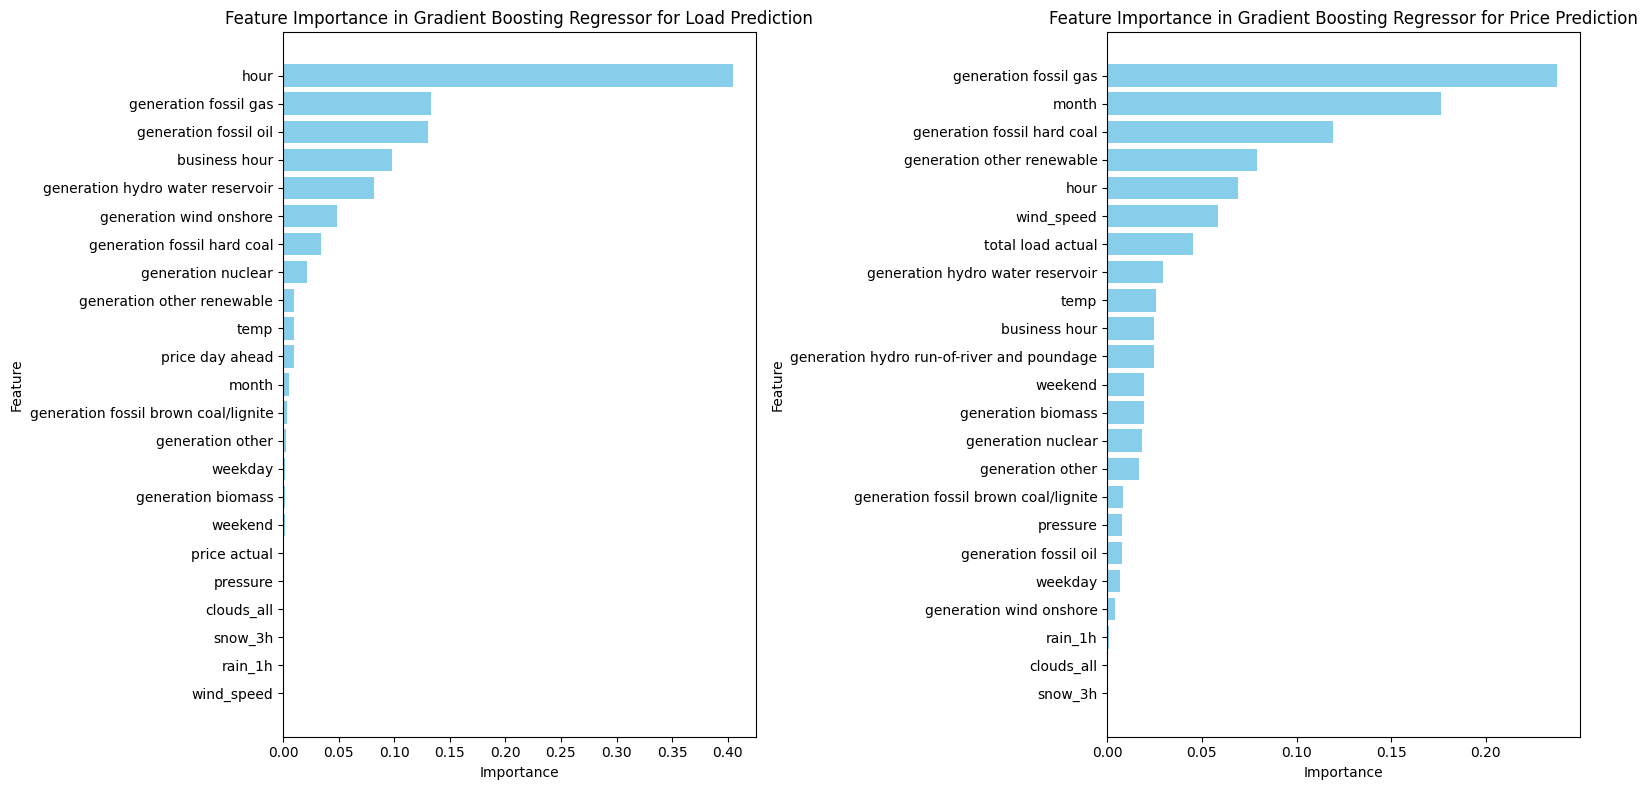

In [ ]:
# Plot the bar plot of the most important variables for total load
importance_load = gbr_load.feature_importances_
features_load = X_train_load.columns
importance_df_load = pd.DataFrame({'Feature': features_load, 'Importance': importance_load})

# Sort the features by importance
importance_df_load = importance_df_load.sort_values(by='Importance', ascending=False)

# Plot the bar plot of the most important variables for price
importance_price = gbr_price.feature_importances_
features_price = X_train.columns
importance_df_price = pd.DataFrame({'Feature': features_price, 'Importance': importance_price})

# Sort the features by importance
importance_df_price = importance_df_price.sort_values(by='Importance', ascending=False)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot for total load actual
ax[0].barh(importance_df_load['Feature'], importance_df_load['Importance'], color='skyblue')
ax[0].set_xlabel('Importance')
ax[0].set_ylabel('Feature')
ax[0].set_title('Feature Importance in Gradient Boosting Regressor for Load Prediction')
ax[0].invert_yaxis()

# Plot for price actual
ax[1].barh(importance_df_price['Feature'], importance_df_price['Importance'], color='skyblue')
ax[1].set_xlabel('Importance')
ax[1].set_ylabel('Feature')
ax[1].set_title('Feature Importance in Gradient Boosting Regressor for Price Prediction')
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Important Valiables for Random Forest Model

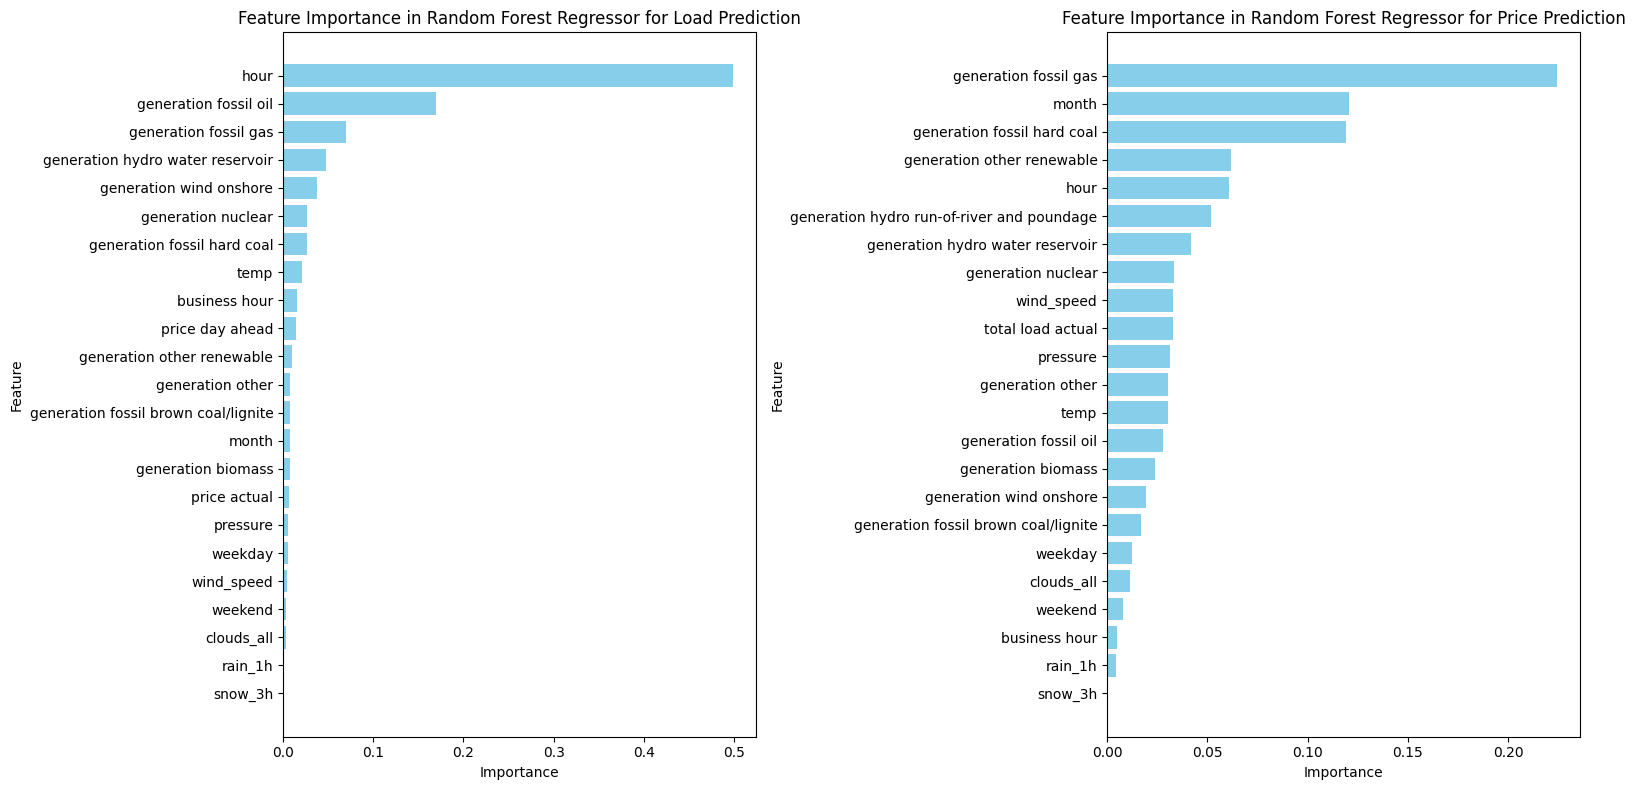

In [ ]:
# Plot the bar plot of the most important variables for total load
importance_load = rf_load.feature_importances_
features_load = X_train_load.columns
importance_df_load = pd.DataFrame({'Feature': features_load, 'Importance': importance_load})

# Sort the features by importance
importance_df_load = importance_df_load.sort_values(by='Importance', ascending=False)

# Plot the bar plot of the most important variables for price
importance_price = rf_price.feature_importances_
features_price = X_train.columns
importance_df_price = pd.DataFrame({'Feature': features_price, 'Importance': importance_price})

# Sort the features by importance
importance_df_price = importance_df_price.sort_values(by='Importance', ascending=False)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot for total load actual
ax[0].barh(importance_df_load['Feature'], importance_df_load['Importance'], color='skyblue')
ax[0].set_xlabel('Importance')
ax[0].set_ylabel('Feature')
ax[0].set_title('Feature Importance in Random Forest Regressor for Load Prediction')
ax[0].invert_yaxis()

# Plot for price actual
ax[1].barh(importance_df_price['Feature'], importance_df_price['Importance'], color='skyblue')
ax[1].set_xlabel('Importance')
ax[1].set_ylabel('Feature')
ax[1].set_title('Feature Importance in Random Forest Regressor for Price Prediction')
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

***Load Prediction Model***:

**Hour**: Most significant feature, indicating the influence of time of day on energy consumption.

**Generation from Fossil Oil and Gas**: Key factors reflecting the impact of fossil fuel-based energy production on total load.

**Generation from Hydro Reservoirs and Wind Onshore**: Important renewable energy sources contributing to load predictions.

***Price Prediction Model***:

**Generation from Fossil Gas**: Most crucial feature, highlighting the direct impact of fossil fuel generation on energy prices.

**Month and Hour**: Significant time-related features showing seasonal and daily variations in energy prices.

**Generation from Other Renewables and Hydro Run-of-River**: Important renewable sources affecting price stability.

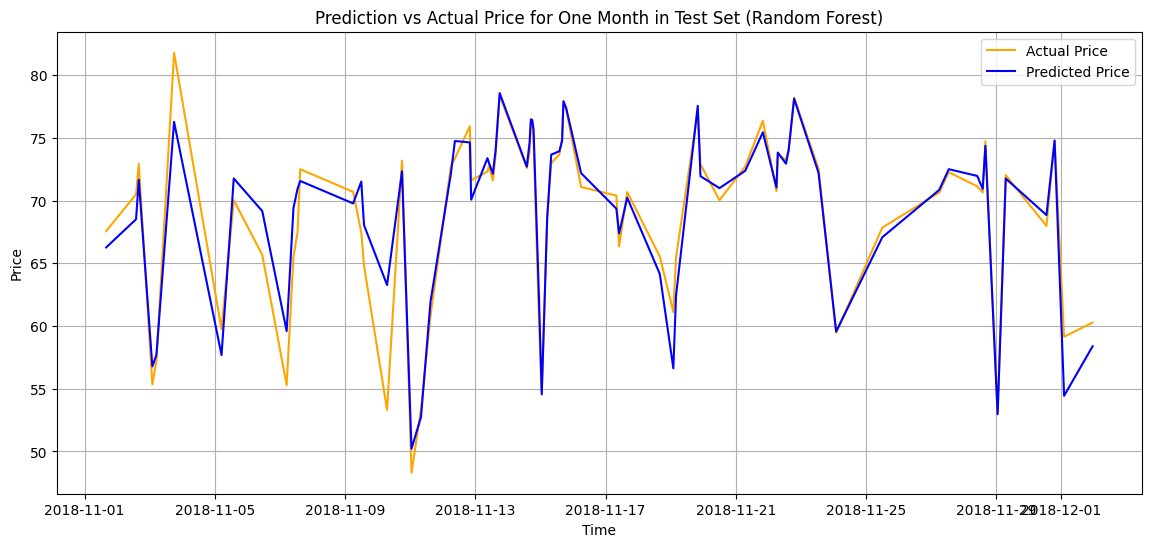

In [ ]:
import matplotlib.pyplot as plt

# Ensure the index is sorted
X_test_price = X_test.sort_index()
y_test_price = y_test.sort_index()

# Define the desired time range
start_date = '2018-11-01'
end_date = '2018-12-01'

# Filter the data to include only the specified time range
filtered_X_test_price = X_test_price.loc[start_date:end_date]
filtered_y_test_price = y_test_price.loc[start_date:end_date]

# Predictions using the Random Forest Regressor model for the filtered data
filtered_y_pred_price = rf_price.predict(filtered_X_test_price)

# Plotting the prediction vs actual price with time axis
plt.figure(figsize=(14, 6))  # Adjusted figure size

# Use the index as the x-axis
time_axis = filtered_X_test_price.index

# Plot the actual and predicted prices with time axis
plt.plot(time_axis, filtered_y_test_price, label='Actual Price', color='orange')
plt.plot(time_axis, filtered_y_pred_price, label='Predicted Price', color='blue', linestyle='-')

plt.title('Prediction vs Actual Price for One Month in Test Set (Random Forest)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)  # Added grid lines
plt.show()


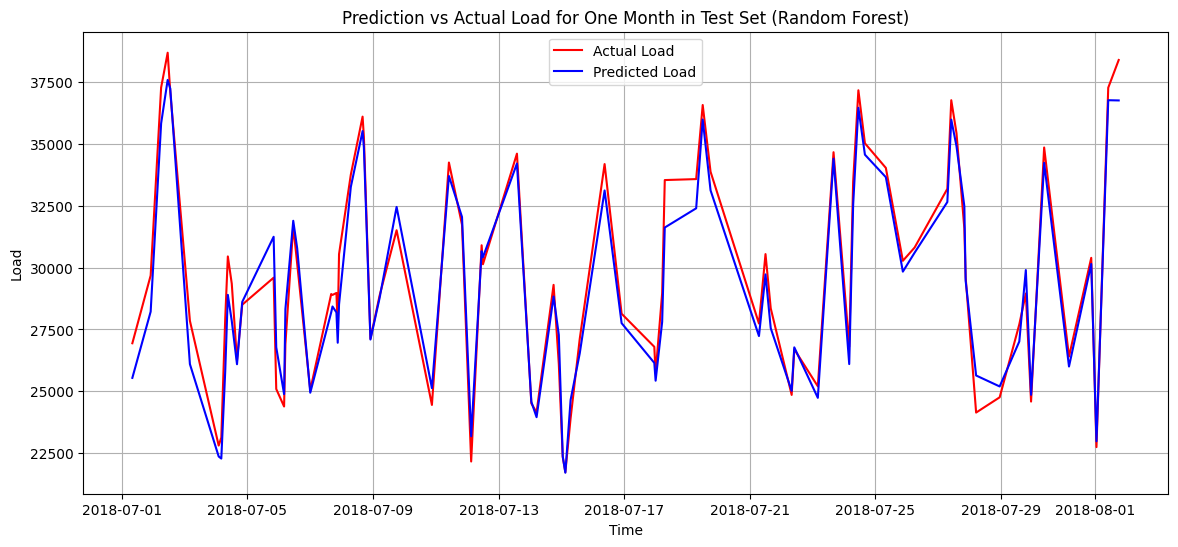

In [ ]:

# Ensure the index is sorted
X_test_load = X_test_load.sort_index()
y_test_load = y_test_load.sort_index()

# Define the desired time range (one month from 2018 or 2019)
start_date = '2018-07-01'
end_date = '2018-08-01'

# Filter the data to include only the specified time range
filtered_X_test_load = X_test_load.loc[start_date:end_date]
filtered_y_test_load = y_test_load.loc[start_date:end_date]

# Predictions using the Random Forest Regressor model for the filtered data
filtered_y_pred_load = rf_load.predict(filtered_X_test_load)

# Plotting the prediction vs actual load with time axis
plt.figure(figsize=(14, 6))  # Adjusted figure size

# Use the index as the x-axis
time_axis = filtered_X_test_load.index

# Plot the actual and predicted loads with time axis
plt.plot(time_axis, filtered_y_test_load.reset_index(drop=True), label='Actual Load', color='red')
plt.plot(time_axis, filtered_y_pred_load, label='Predicted Load', color='blue', linestyle='-')

plt.title('Prediction vs Actual Load for One Month in Test Set (Random Forest)')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)  # Added grid lines
plt.show()


Actual vs Prediction of Load for one month dueration form validation data by Random forest model

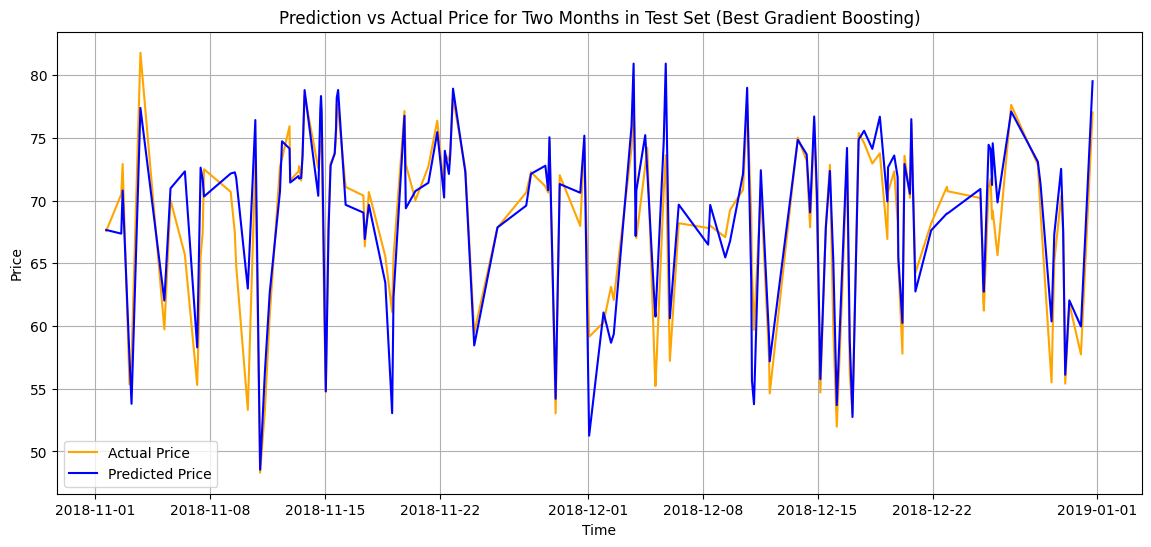

In [ ]:
# Ensure the index is sorted
X_test_price = X_test.sort_index()
y_test_price = y_test.sort_index()

# Define the desired time range
start_date = '2018-11-01'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
filtered_X_test_price = X_test_price.loc[start_date:end_date]
filtered_y_test_price = y_test_price.loc[start_date:end_date]

# Predictions using the best model for the filtered data
filtered_y_pred_price = best_gbr.predict(filtered_X_test_price)

# Plotting the prediction vs actual price with time axis
plt.figure(figsize=(14, 6))  # Adjusted figure size

# Use the index as the x-axis
time_axis = filtered_X_test_price.index

# Plot the actual and predicted prices with time axis
plt.plot(time_axis, filtered_y_test_price, label='Actual Price', color='orange')
plt.plot(time_axis, filtered_y_pred_price, label='Predicted Price', color='blue', linestyle='-')

plt.title('Prediction vs Actual Price for Two Months in Test Set (Best Gradient Boosting)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)  # Added grid lines
plt.show()

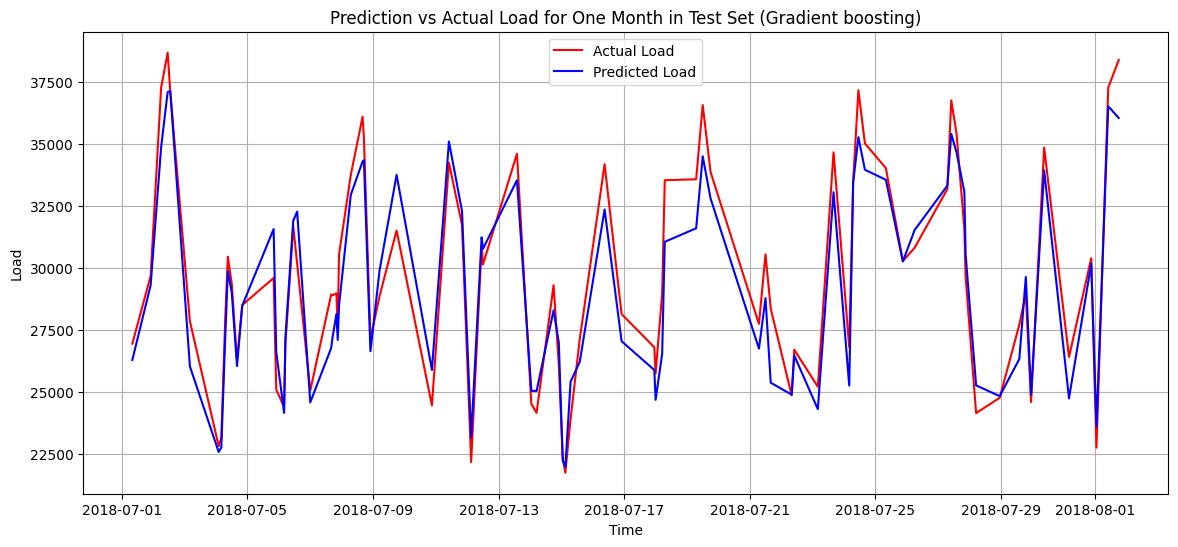

In [ ]:

# Ensure the index is sorted
X_test_load = X_test_load.sort_index()
y_test_load = y_test_load.sort_index()

# Define the desired time range (one month from 2018 or 2019)
start_date = '2018-07-01'
end_date = '2018-08-01'

# Filter the data to include only the specified time range
filtered_X_test_load = X_test_load.loc[start_date:end_date]
filtered_y_test_load = y_test_load.loc[start_date:end_date]

# Predictions using the Gradient boosting  Regressor model for the filtered data
filtered_y_pred_load = gbr_load.predict(filtered_X_test_load)

# Plotting the prediction vs actual load with time axis
plt.figure(figsize=(14, 6))  # Adjusted figure size

# Use the index as the x-axis
time_axis = filtered_X_test_load.index

# Plot the actual and predicted loads with time axis
plt.plot(time_axis, filtered_y_test_load.reset_index(drop=True), label='Actual Load', color='red')
plt.plot(time_axis, filtered_y_pred_load, label='Predicted Load', color='blue', linestyle='-')

plt.title('Prediction vs Actual Load for One Month in Test Set (Gradient boosting)')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.show()
